In [1]:
### DEFINING EXTRACTION UNIVERSE DATA FROM GENERAL MS EXCEL SOURCE
def get_market_membership_from_excel(path_msci):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Declaring local constants & variables: 
    tab_monthly = 'universe_joined'    
    arr_markets_needed = ['DM', 'FM', 'EM']   
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM'}
    no_slice = slice(None)
    ### Extracting universe data:
    df_universe = pd.read_excel(io = path_msci, sheet_name = tab_monthly, skiprows = [0, 2], header = 0, parse_dates = True, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    df_universe = df_universe.loc[no_slice, ['dates', 'region', 'ctry']]
    df_universe.columns = ['Date', 'Market', 'Country']
    df_universe.set_index(['Date', 'Country'], inplace = True)
    ser_universe = df_universe.squeeze()
    ser_universe.sort_index(level = [0, 1], inplace = True)
    ser_universe.replace(dict_markets, inplace = True)
    ser_market_membership = ser_universe[ser_universe.isin(arr_markets_needed)]
    
    return ser_market_membership

In [2]:
### DEFINING EXTRACTION ISO COUNTRY CODES
def get_country_codes(use_local_copy = False):  
    ### Importing standard modules and date-special modules:    
    import pandas as pd
    ### Choosing local copy or direct link:
    if (use_local_copy):
        url_country_code = 'Data_Files/Source_Files/countrycode.html'
    else:
        url_country_code = 'https://countrycode.org/'
    ### Loading data:
    df_full_codes = pd.read_html(url_country_code, index_col = 'COUNTRY')[0]
    ### Dividing ISO codes:
    df_full_codes[['ISO SHORT', 'ISO LONG']] = df_full_codes['ISO CODES'].str.split(' / ', expand = True)
    ### Codes polishing:
    df_result_codes = df_full_codes[['ISO SHORT', 'ISO LONG']]      
    df_result_codes.index = df_result_codes.index.str.upper()
    
    return df_result_codes

In [3]:
def get_political_data(path_politics, path_msci):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Constants declaring:
    dict_map_to_replace = {'CONGO': 'Republic of the Congo', 
                           'CONGO, DR': 'Democratic Republic of the Congo',
                           'CÔTE D’IVOIRE': 'Ivory Coast',
                           'CZECHOSLOVAKIA': np.NaN,
                           'GERMANY, EAST': np.NaN,
                           'GERMANY, WEST': 'Germany',
                           'KOREA, DPR': 'North Korea',
                           'KOREA, SOUTH': 'South Korea',
                           'SERBIA-MONTENEGRO': 'Serbia',
                           'TRINIDAD & TOBAGO': 'Trinidad and Tobago',
                           'UAE': 'United Arab Emirates',
                           'USSR': np.NaN} ### For ratings harmonizing    
    ### Loading data:
    df_politics = pd.read_excel(path_politics, index_col = [0, 1], parse_dates = True)
    ### Mungling table:
    df_politics = df_politics.stack().unstack('Variable')
    df_politics.index.names = ['COUNTRY', 'Month']
    df_politics.columns.name = ''    
    ### Text Month to business end-of-month converting:
    df_politics.reset_index('Month', inplace = True)
    df_politics['Date'] = pd.to_datetime(df_politics['Month'].str.split('/', expand = True)[1].astype(str) + \
                                         df_politics['Month'].str.split('/', expand = True)[0].astype(str), format = '%Y%m') + pd.offsets.BMonthEnd()
    df_politics.set_index('Date', append = True, inplace = True)    
    df_politics.drop('Month', axis = 1, inplace = True)
    ### Preparing for Country Name to Country code converting:
    df_politics.reset_index('COUNTRY', inplace = True)
    df_politics['COUNTRY'] = df_politics['COUNTRY'].str.upper()
    ### Countries names harmonizing with ISO table:
    for map_key, map_value in dict_map_to_replace.items():
        df_politics['COUNTRY'] = df_politics['COUNTRY'].replace(map_key, map_value)
    df_politics = df_politics[df_politics['COUNTRY'].notna()]
    df_politics['COUNTRY'] = df_politics['COUNTRY'].str.upper()    
    df_politics.set_index('COUNTRY', append = True, inplace = True)    
    ### ISO Country codes inserting:
    df_politics = df_politics.join(get_country_codes(), on = 'COUNTRY', how = 'left')   
    df_politics.reset_index('COUNTRY', drop = True, inplace = True)
    df_politics.set_index('ISO SHORT', append = True, inplace = True)
    df_politics.drop('ISO LONG', axis = 1, inplace = True)   
    df_politics.index.names = ['Date', 'Country']
    ### Market membership importing:
    ser_market_membership = get_market_membership_from_excel(path_msci)
    ### Adding membership column to result dataframe:    
    df_politics = df_politics.join(ser_market_membership, on = ['Date', 'Country'], how = 'left')
    df_politics = df_politics.set_index('Market', drop = True, append = True)    
    ### Dropping countries with no participation in ISOIN universe:
    df_politics = df_politics.loc[(All, ser_market_membership.index.get_level_values(1).unique().to_list(), All), All]
    
    return df_politics

In [19]:
### MAIN SCRIPT
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
### Declaring global constants & variables: 
path_msci = 'Data_Files/Source_Files/sample_universe.xlsx' ### Path for membership source
path_politics_2019_10 = 'Data_Files/Source_Files/political_risk_2019_10.xlsx' ### Path for risk data
path_politics_2020_01 = 'Data_Files/Source_Files/political_risk_2020_01.xlsx' ### Path for risk data
All = slice(None)
#get_market_membership_from_excel(path_msci)
df_politics_2019_10 = get_political_data(path_politics_2019_10, path_msci)
df_politics_2019_10 = df_politics_2019_10.loc[(All, All, All), ['Composite Risk Rating', 'Economic Risk Rating', 'Financial Risk Rating', 'Political Risk Rating']]
df_politics_2019_10.to_excel('Data_Files/Test_Files/Political_Risk_Stacked_2019_10.xlsx', merge_cells = False)
df_politics_2020_01 = get_political_data(path_politics_2020_01, path_msci)
df_politics_2020_01 = df_politics_2020_01.loc[(All, All, All), ['Composite Risk Rating', 'Economic Risk Rating', 'Financial Risk Rating', 'Political Risk Rating']]
df_politics_2020_01.to_excel('Data_Files/Test_Files/Political_Risk_Stacked_2020_01.xlsx', merge_cells = False)

In [23]:
### SOURCES COMAPRING
df_politics_compare = (df_politics_2020_01.loc[df_politics_2020_01.index.intersection(df_politics_2019_10.index)] - df_politics_2019_10).abs()
df_politics_compare.sum()

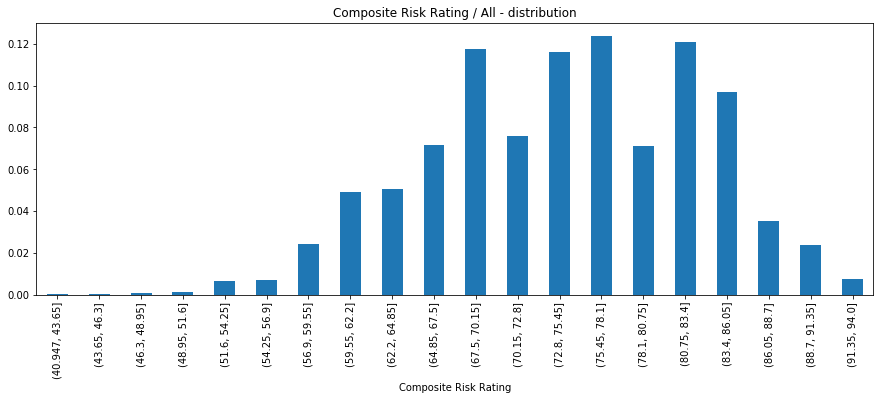

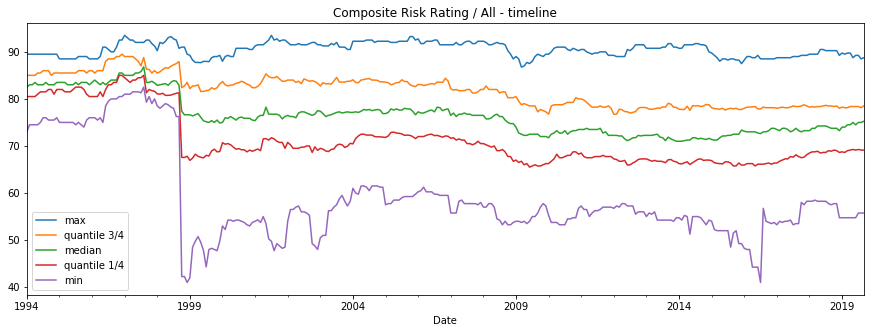

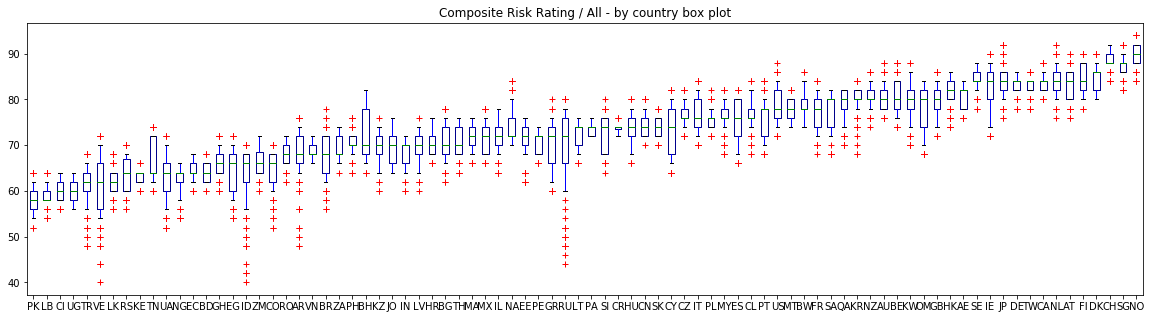

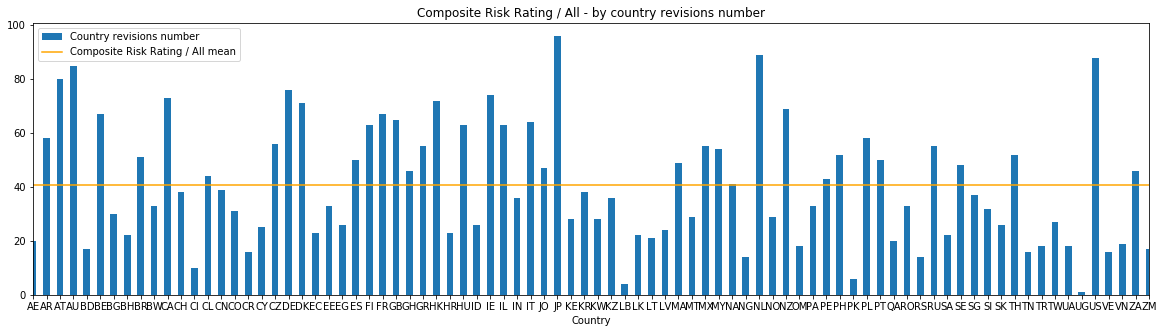

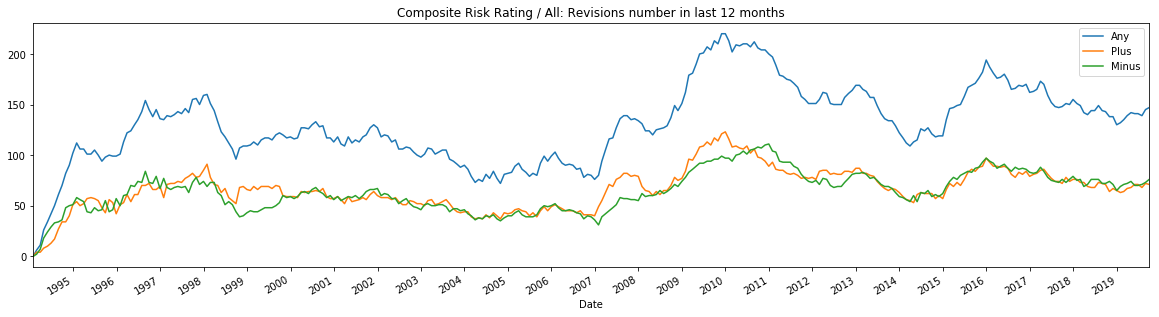

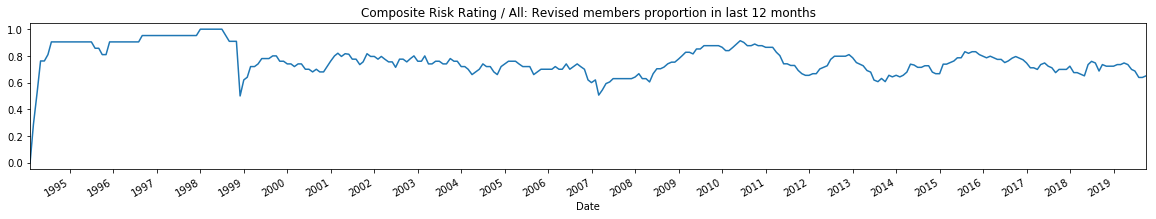

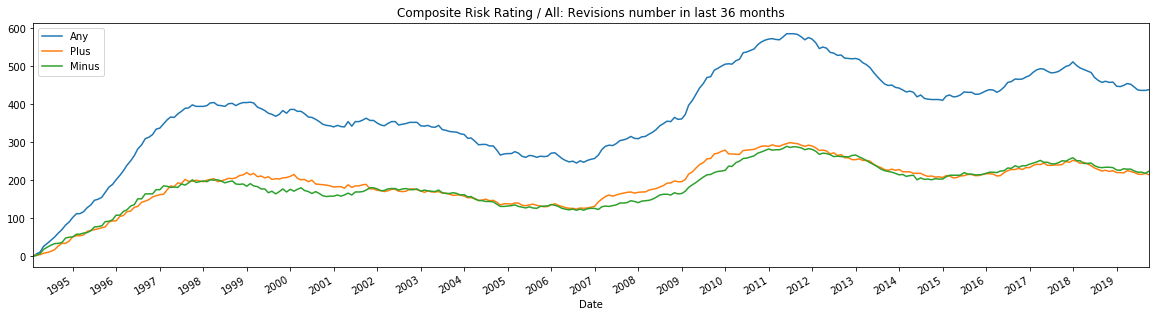

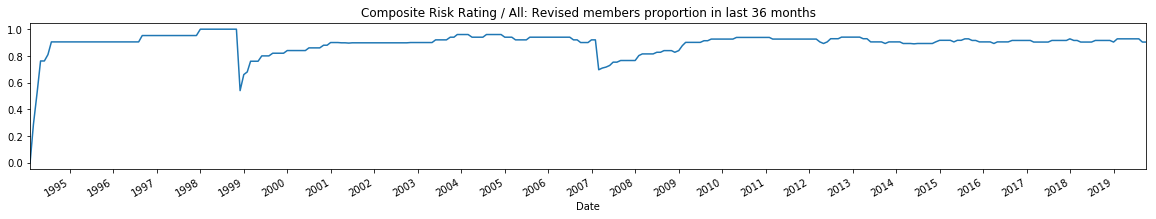

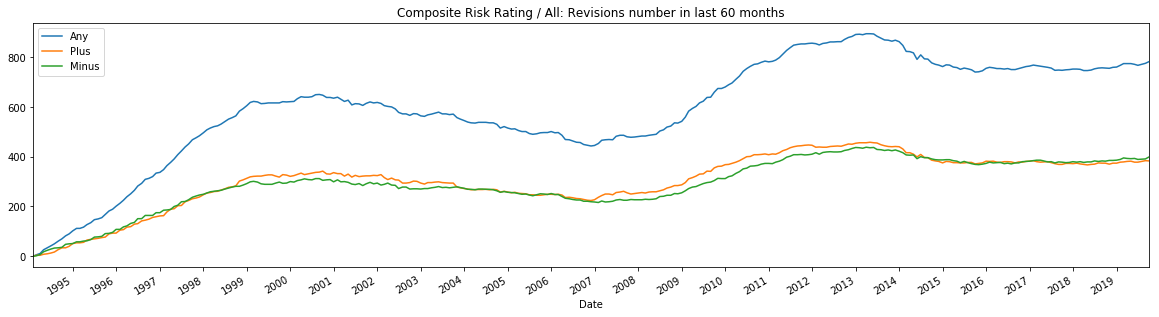

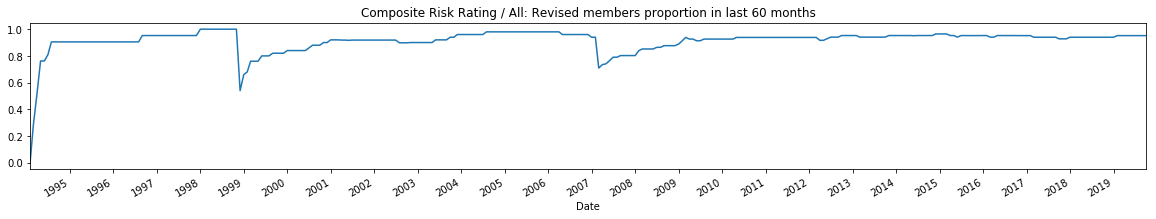

Composite Risk Rating : All markets ( 18758 ) : Countries covered: 84
Composite Risk Rating : All markets ( 18758 ) : Average observations per country: 223.31
Composite Risk Rating : All markets ( 18758 ) : Mean coverage per country: 100.00%
Composite Risk Rating : All markets ( 18758 ) : Any revisions frequency: 18.28% ( 3429 )
Composite Risk Rating : All markets ( 18758 ) : Positive revisions frequency: 9.28% ( 1741 )
Composite Risk Rating : All markets ( 18758 ) : Negative revisions frequency: 9.00% ( 1688 )
Composite Risk Rating : All markets ( 18758 ) : Average revisions number for country: 40.82
Composite Risk Rating : All markets ( 18758 ) : Average stable rating period lentgh (months): 5.34
Composite Risk Rating : All markets: Mean revision absolute step: 1.09
Composite Risk Rating : All markets: Mean revision positive step: 1.1
Composite Risk Rating : All markets: Mean revision negative step: -1.08
Composite Risk Rating : All markets: Mean cross-sectional interquantile range (

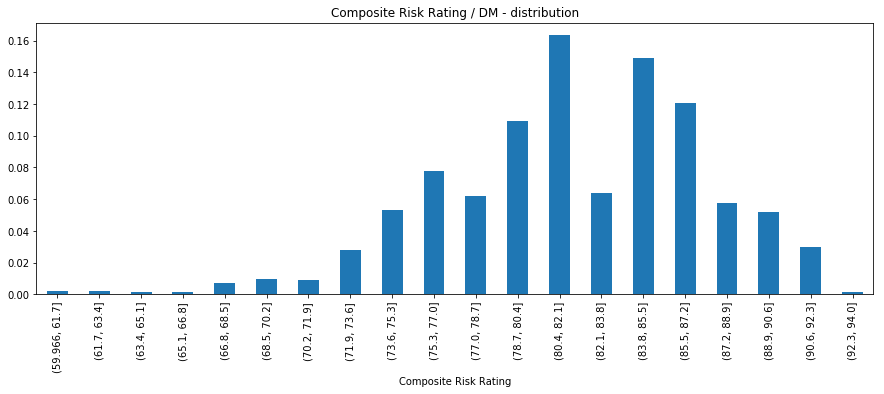

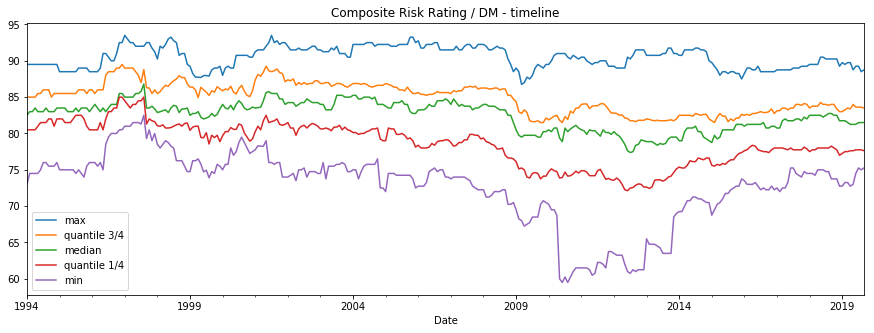

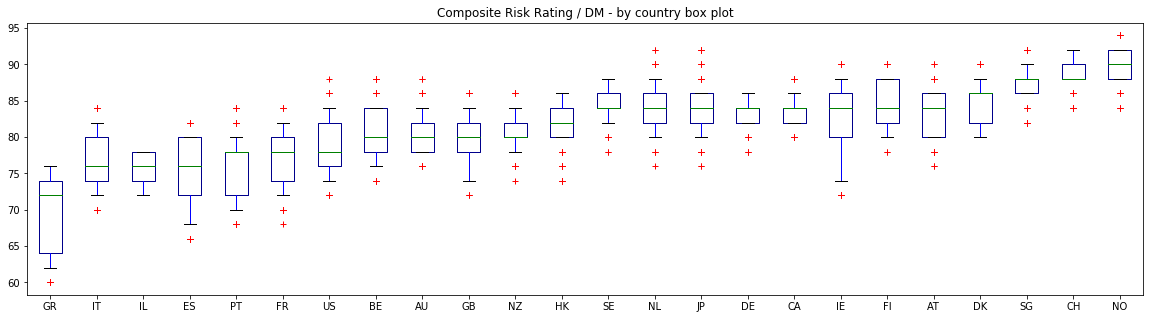

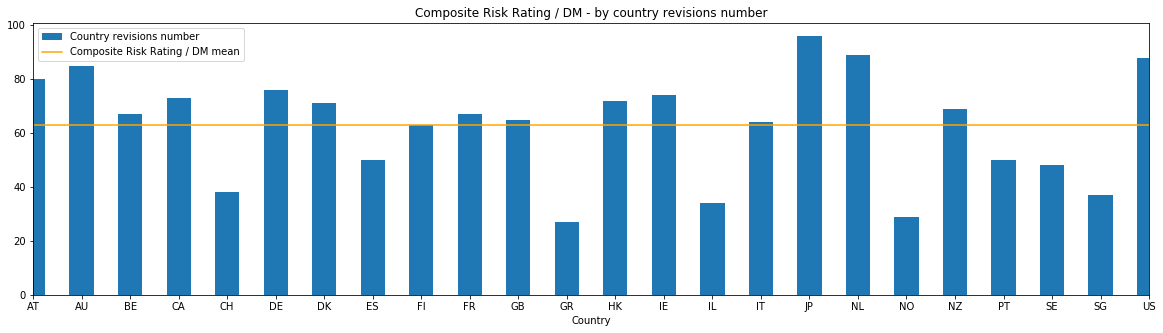

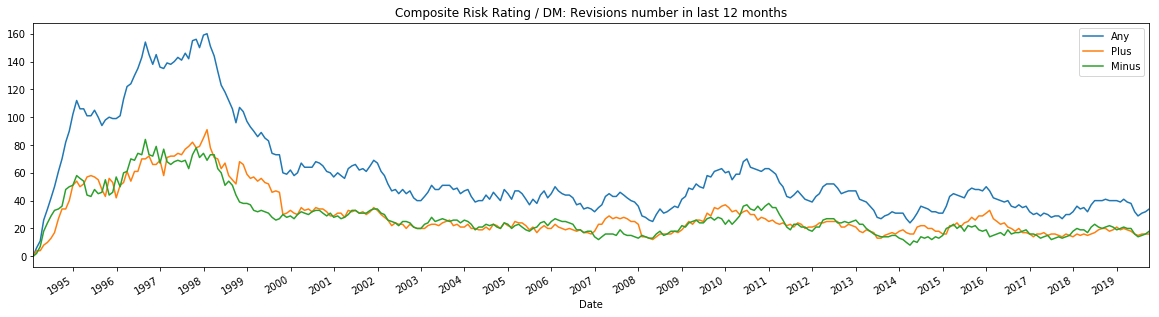

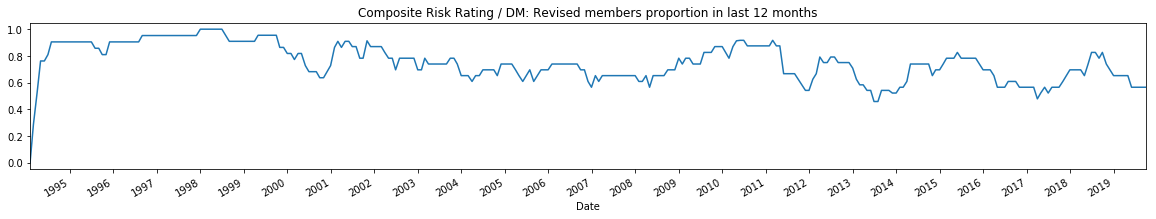

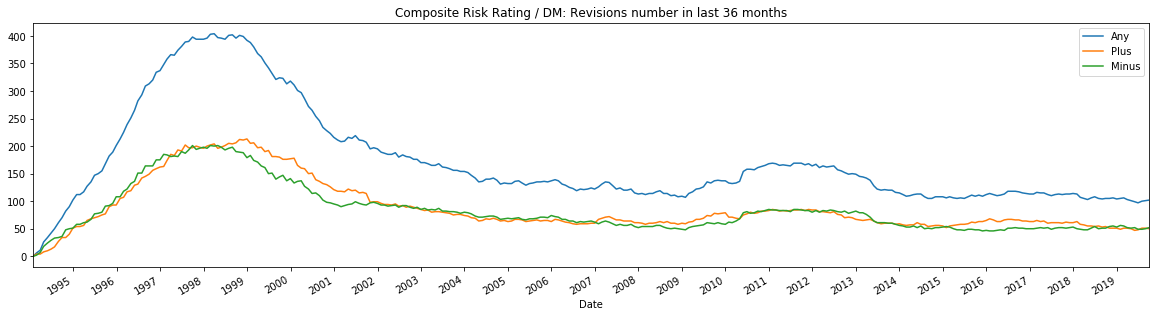

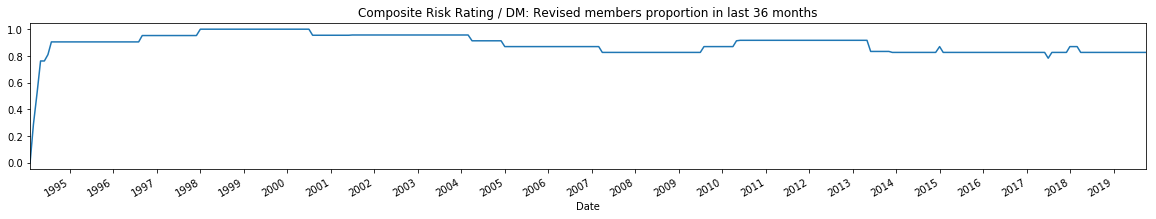

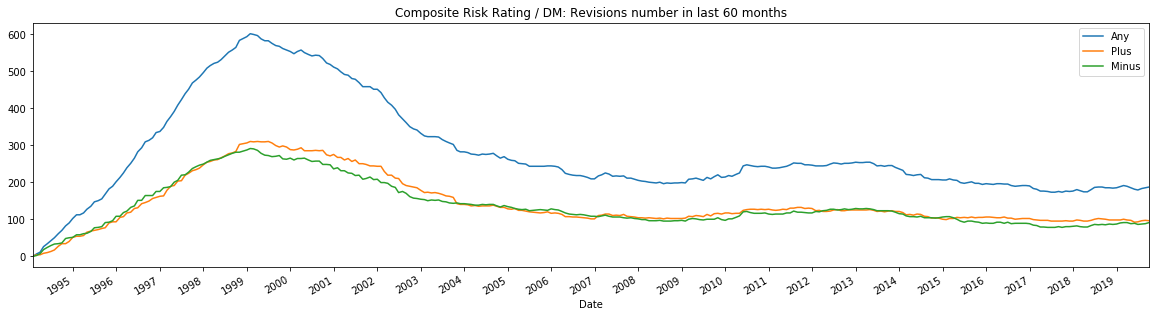

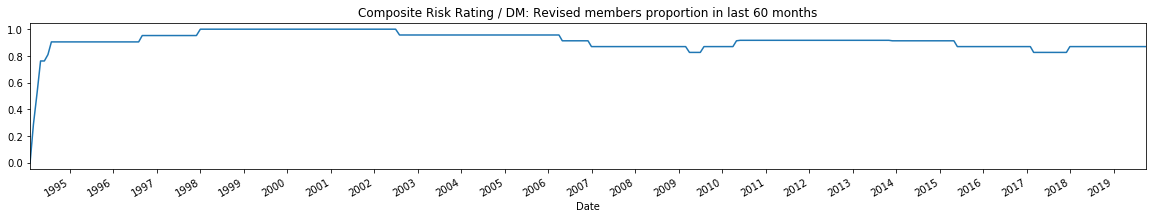

Composite Risk Rating : DM markets ( 7013 ) : Countries covered: 24
Composite Risk Rating : DM markets ( 7013 ) : Average observations per country: 292.21
Composite Risk Rating : DM markets ( 7013 ) : Mean coverage per country: 100.00%
Composite Risk Rating : DM markets ( 7013 ) : Any revisions frequency: 21.56% ( 1512 )
Composite Risk Rating : DM markets ( 7013 ) : Positive revisions frequency: 11.05% ( 775 )
Composite Risk Rating : DM markets ( 7013 ) : Negative revisions frequency: 10.51% ( 737 )
Composite Risk Rating : DM markets ( 7013 ) : Average revisions number for country: 63.0
Composite Risk Rating : DM markets ( 7013 ) : Average stable rating period lentgh (months): 4.57
Composite Risk Rating : DM markets: Mean revision absolute step: 1.15
Composite Risk Rating : DM markets: Mean revision positive step: 1.17
Composite Risk Rating : DM markets: Mean revision negative step: -1.13
Composite Risk Rating : DM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 

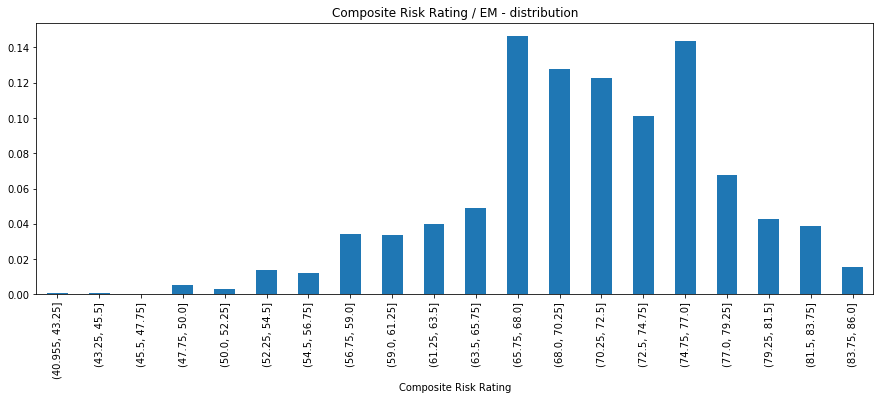

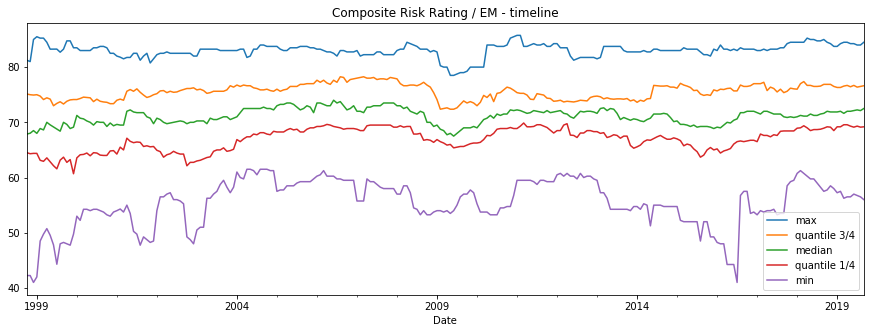

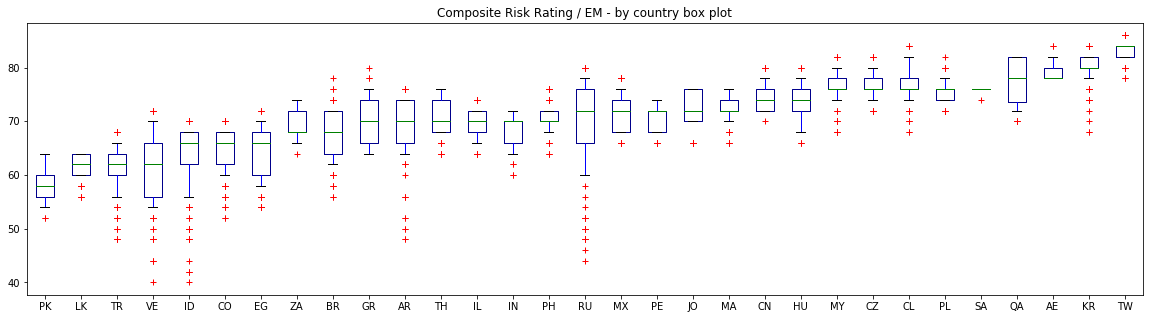

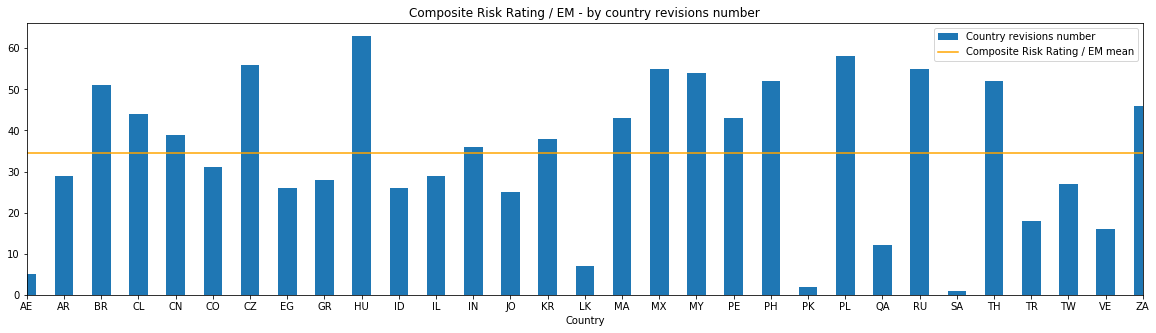

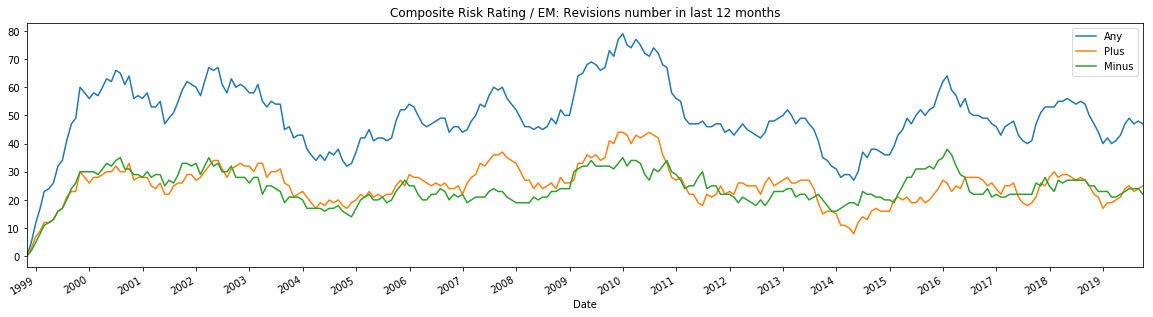

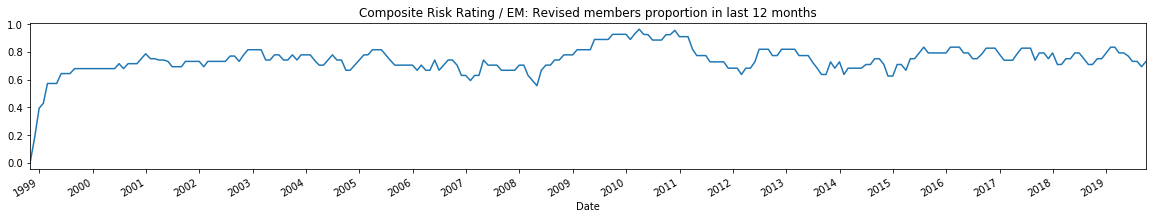

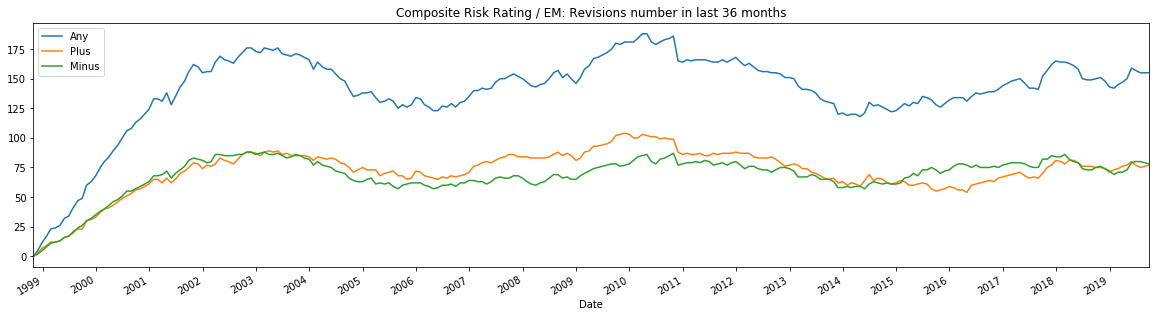

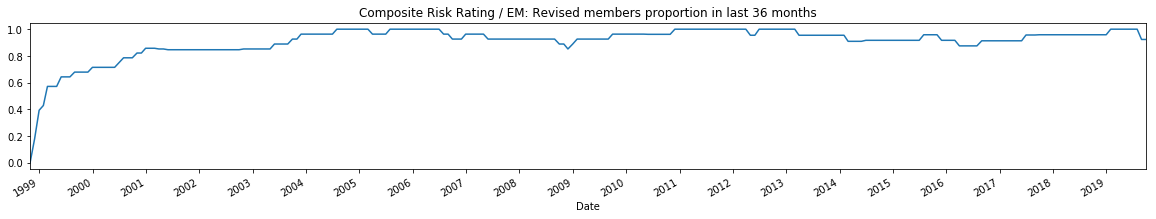

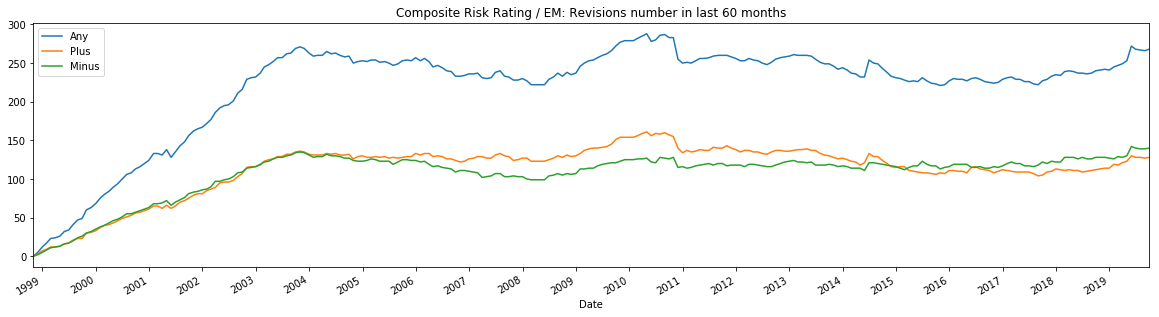

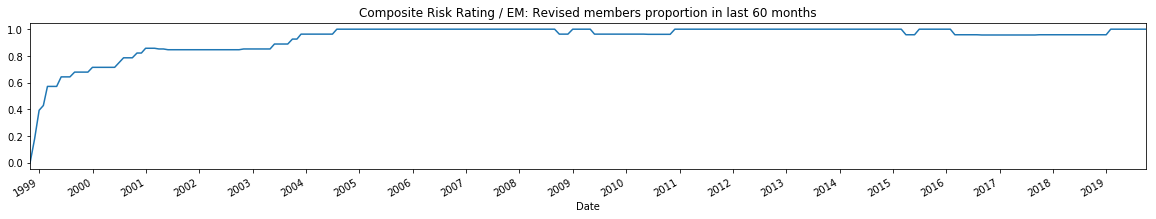

Composite Risk Rating : EM markets ( 6400 ) : Countries covered: 31
Composite Risk Rating : EM markets ( 6400 ) : Average observations per country: 206.45
Composite Risk Rating : EM markets ( 6400 ) : Mean coverage per country: 100.00%
Composite Risk Rating : EM markets ( 6400 ) : Any revisions frequency: 16.67% ( 1067 )
Composite Risk Rating : EM markets ( 6400 ) : Positive revisions frequency: 8.52% ( 545 )
Composite Risk Rating : EM markets ( 6400 ) : Negative revisions frequency: 8.16% ( 522 )
Composite Risk Rating : EM markets ( 6400 ) : Average revisions number for country: 34.42
Composite Risk Rating : EM markets ( 6400 ) : Average stable rating period lentgh (months): 5.81
Composite Risk Rating : EM markets: Mean revision absolute step: 1.03
Composite Risk Rating : EM markets: Mean revision positive step: 1.03
Composite Risk Rating : EM markets: Mean revision negative step: -1.03
Composite Risk Rating : EM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 q

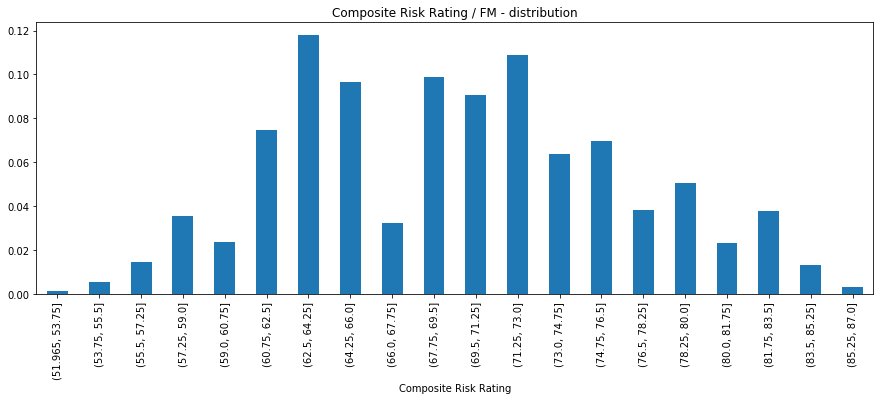

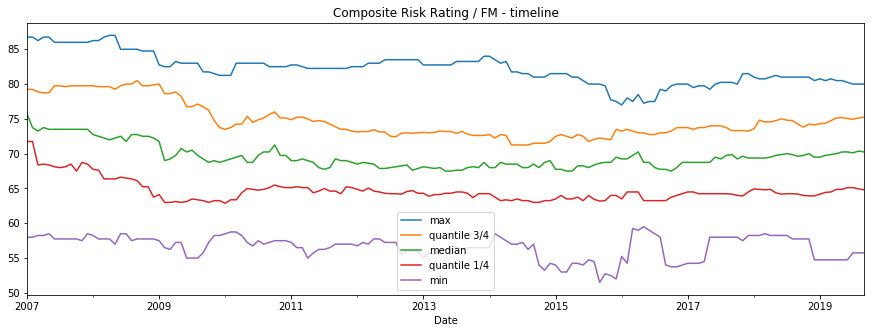

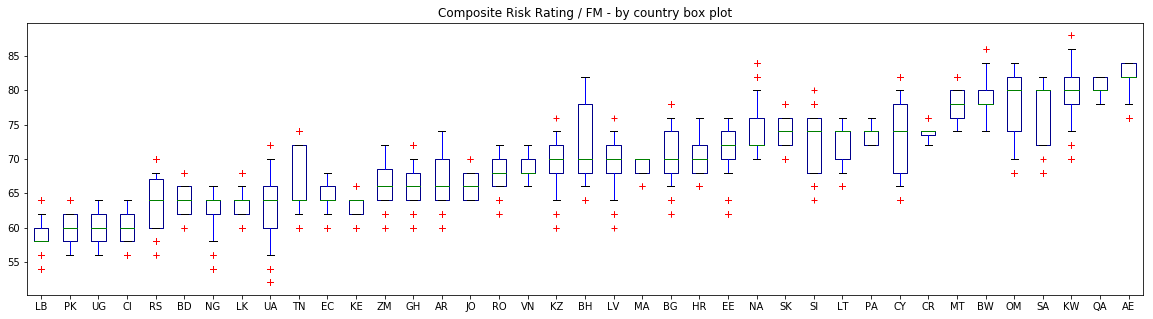

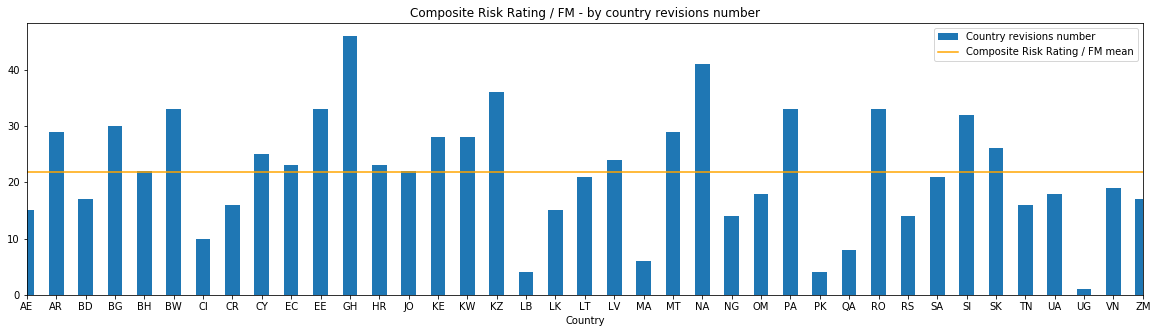

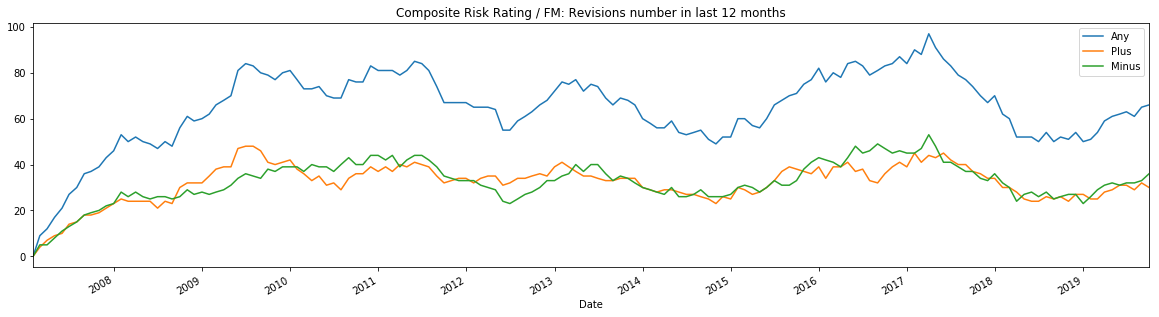

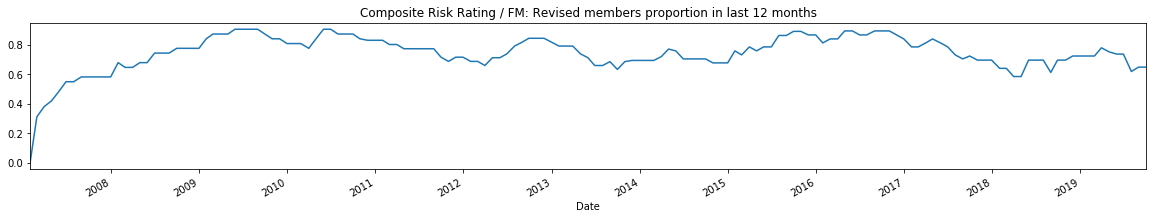

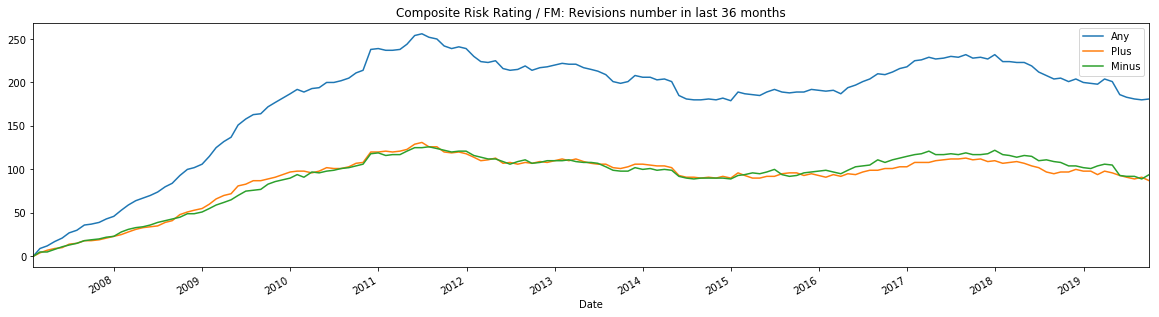

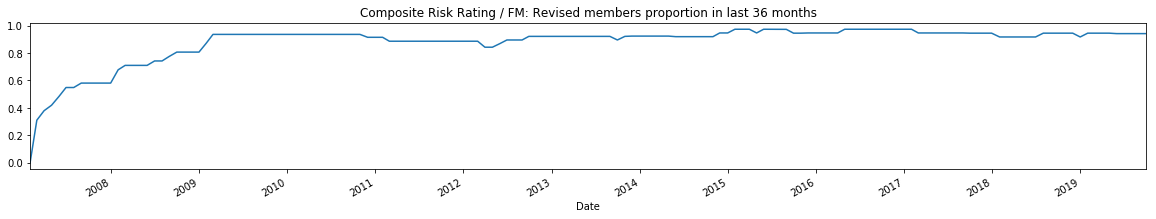

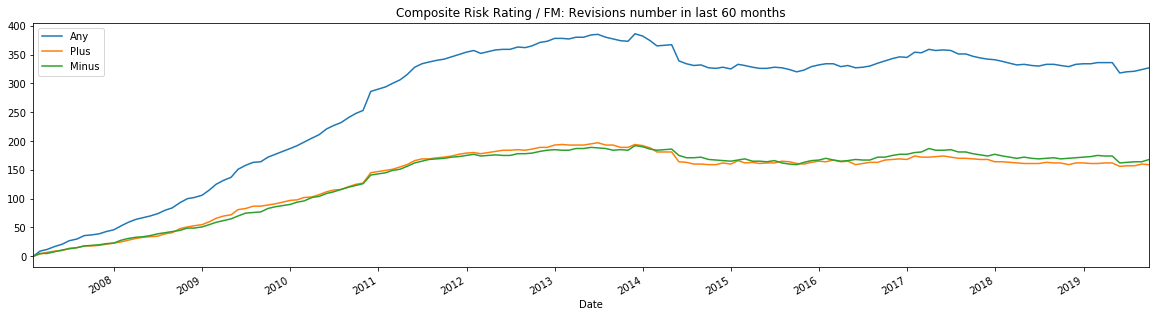

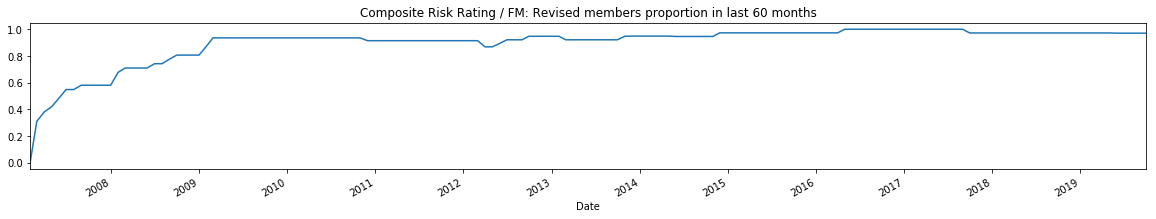

Composite Risk Rating : FM markets ( 5345 ) : Countries covered: 39
Composite Risk Rating : FM markets ( 5345 ) : Average observations per country: 137.05
Composite Risk Rating : FM markets ( 5345 ) : Mean coverage per country: 100.00%
Composite Risk Rating : FM markets ( 5345 ) : Any revisions frequency: 15.90% ( 850 )
Composite Risk Rating : FM markets ( 5345 ) : Positive revisions frequency: 7.88% ( 421 )
Composite Risk Rating : FM markets ( 5345 ) : Negative revisions frequency: 8.03% ( 429 )
Composite Risk Rating : FM markets ( 5345 ) : Average revisions number for country: 21.79
Composite Risk Rating : FM markets ( 5345 ) : Average stable rating period lentgh (months): 6.1
Composite Risk Rating : FM markets: Mean revision absolute step: 1.07
Composite Risk Rating : FM markets: Mean revision positive step: 1.06
Composite Risk Rating : FM markets: Mean revision negative step: -1.07
Composite Risk Rating : FM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 qua

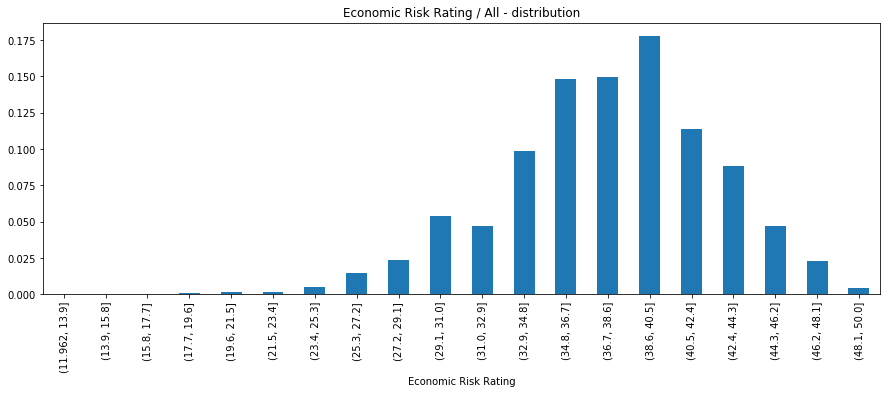

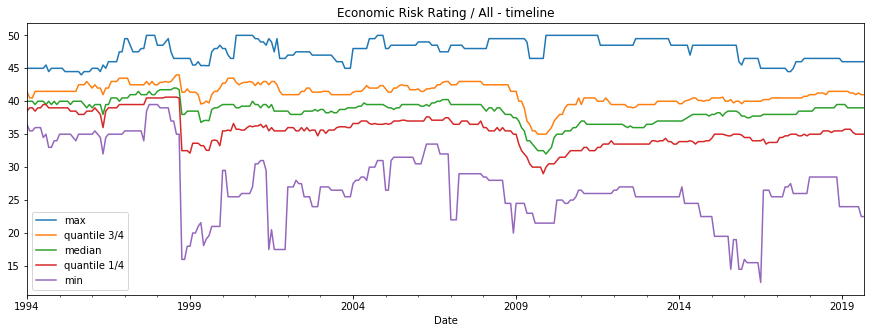

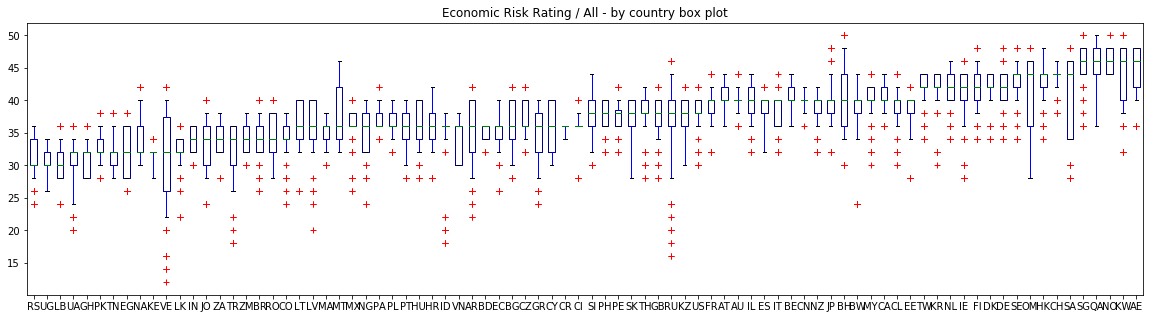

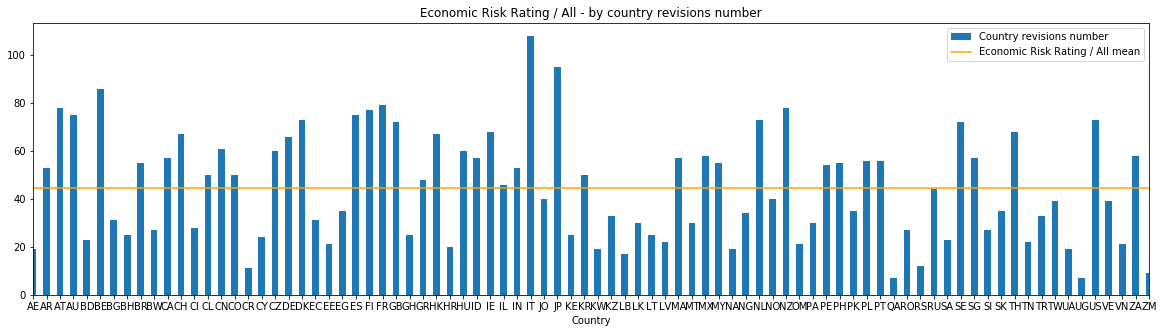

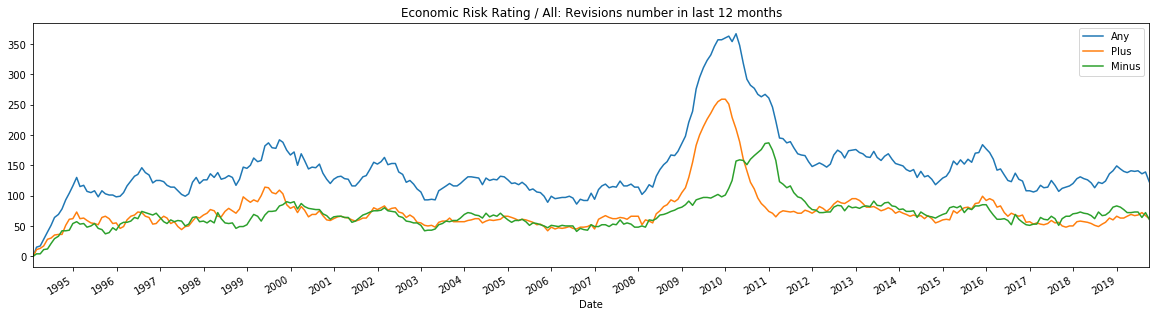

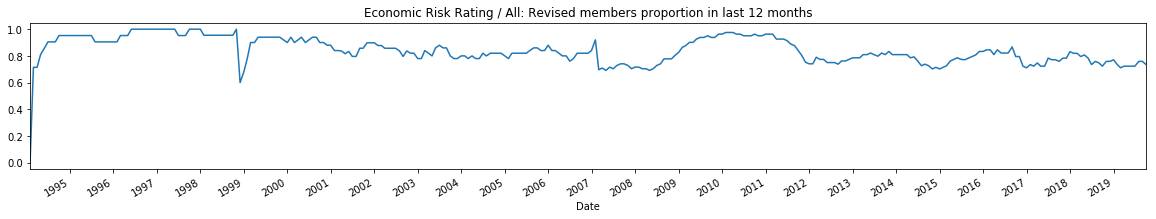

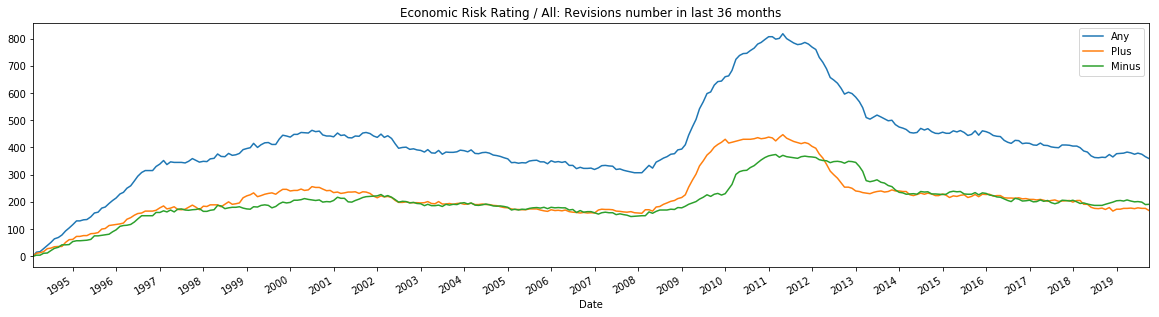

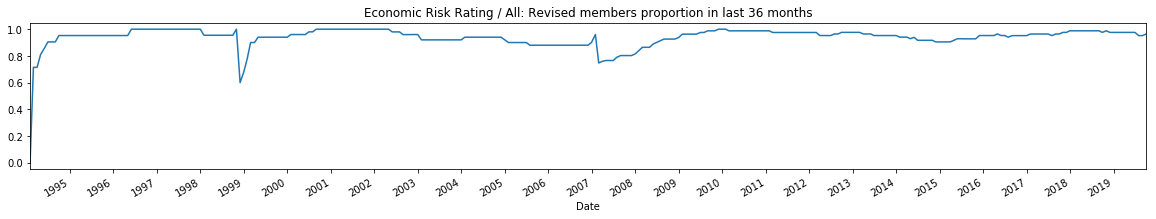

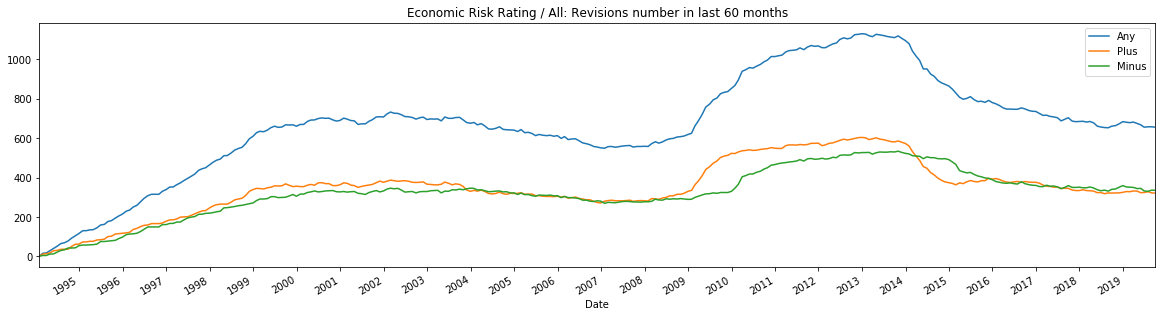

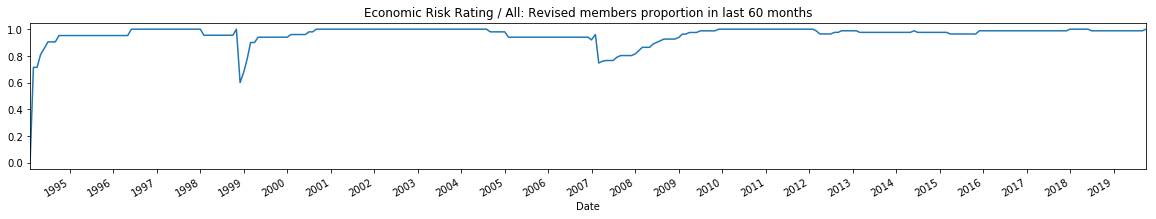

Economic Risk Rating : All markets ( 18758 ) : Countries covered: 84
Economic Risk Rating : All markets ( 18758 ) : Average observations per country: 223.31
Economic Risk Rating : All markets ( 18758 ) : Mean coverage per country: 100.00%
Economic Risk Rating : All markets ( 18758 ) : Any revisions frequency: 20.04% ( 3760 )
Economic Risk Rating : All markets ( 18758 ) : Positive revisions frequency: 10.34% ( 1939 )
Economic Risk Rating : All markets ( 18758 ) : Negative revisions frequency: 9.71% ( 1821 )
Economic Risk Rating : All markets ( 18758 ) : Average revisions number for country: 44.76
Economic Risk Rating : All markets ( 18758 ) : Average stable rating period lentgh (months): 4.88
Economic Risk Rating : All markets: Mean revision absolute step: 1.26
Economic Risk Rating : All markets: Mean revision positive step: 1.25
Economic Risk Rating : All markets: Mean revision negative step: -1.27
Economic Risk Rating : All markets: Mean cross-sectional interquantile range (between 0.

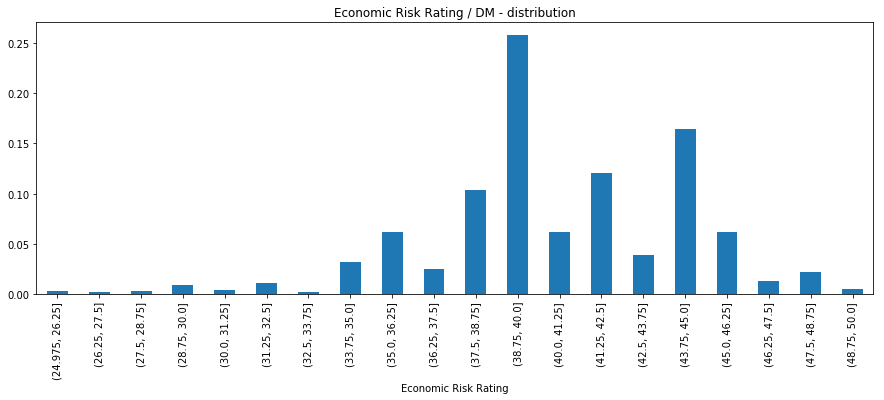

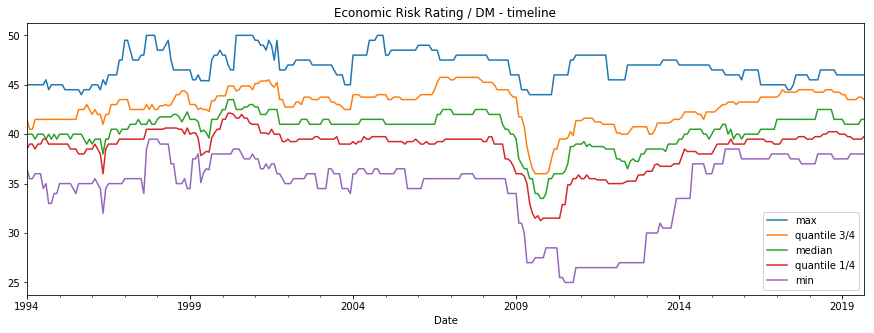

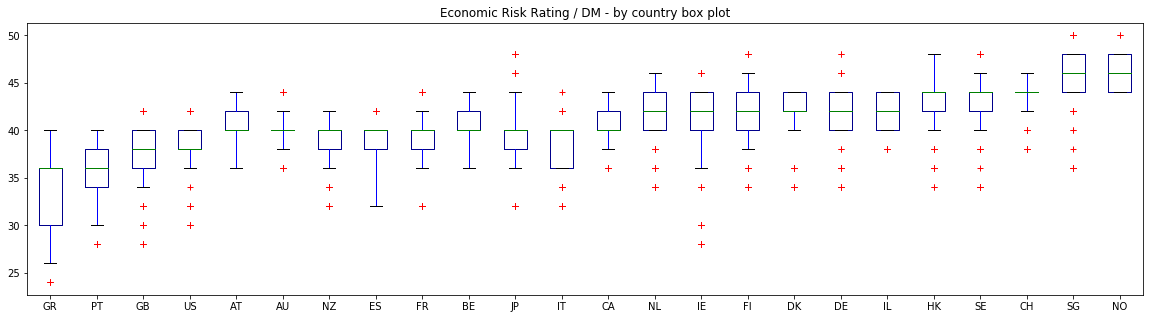

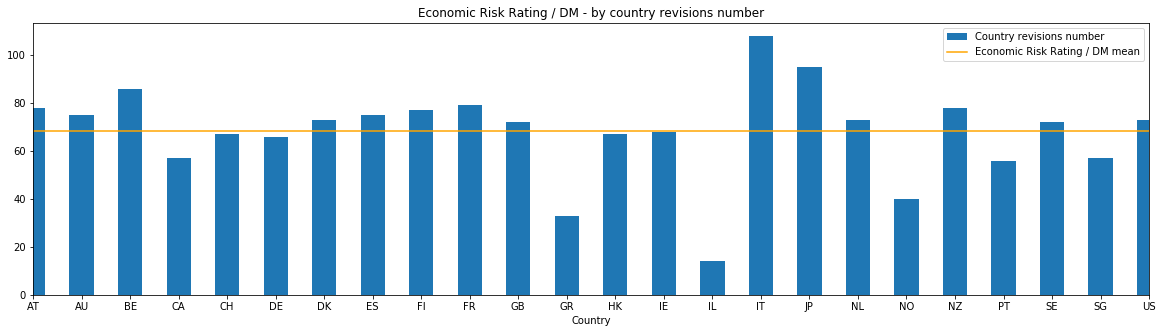

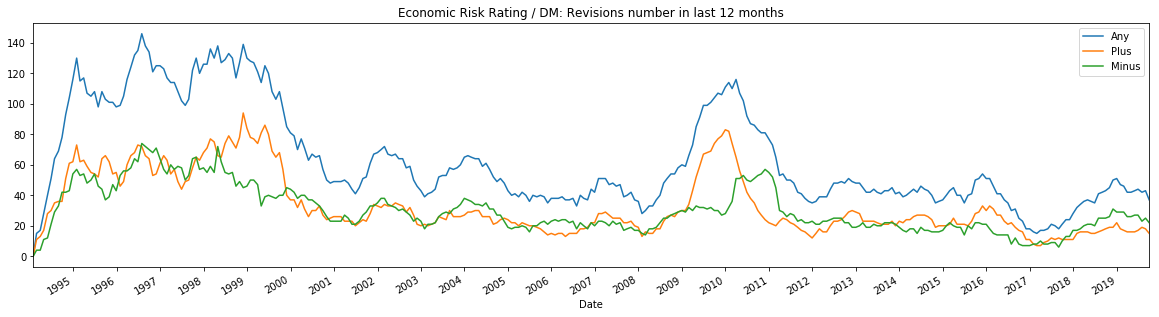

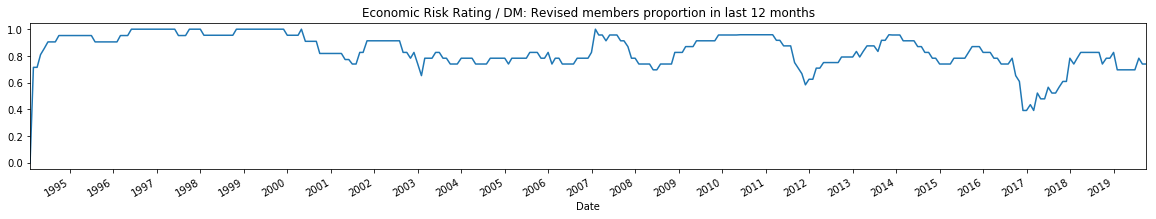

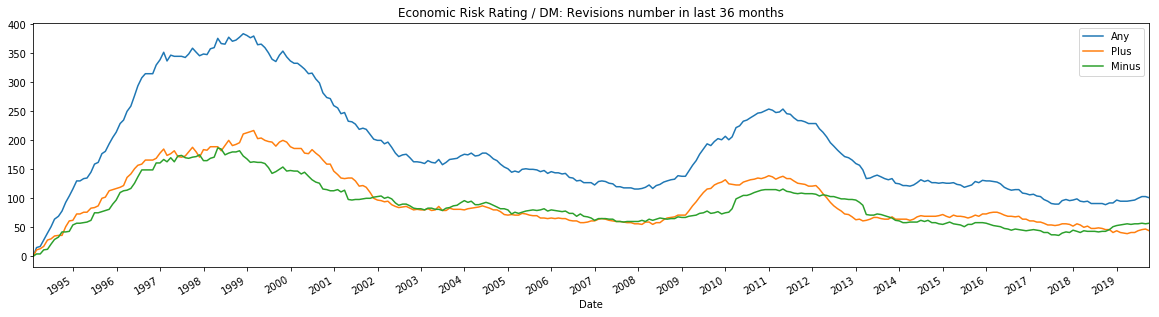

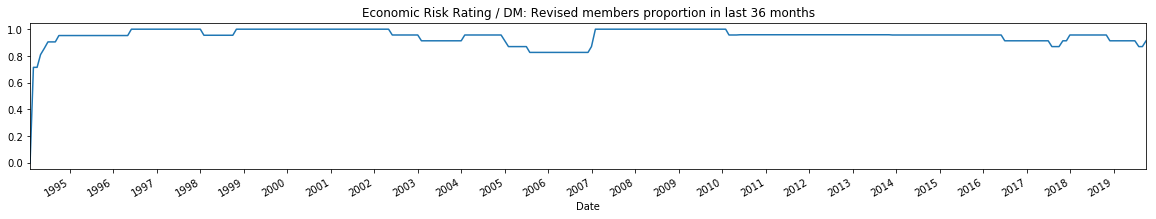

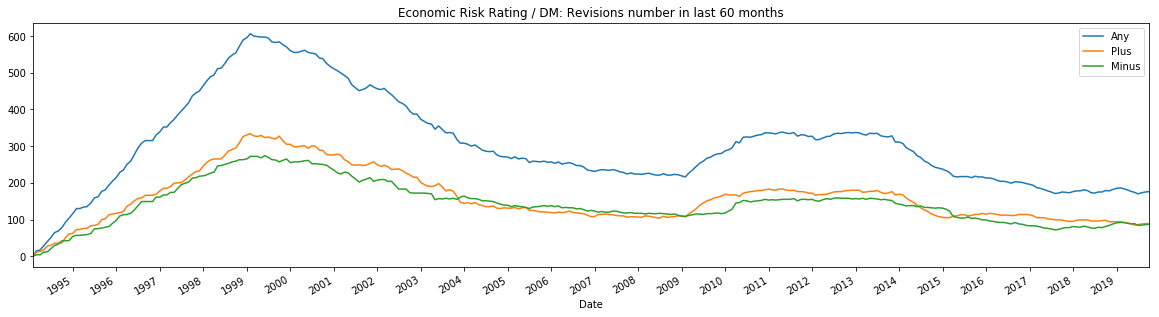

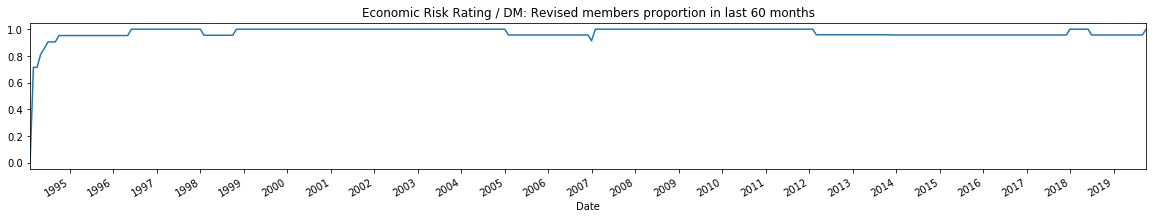

Economic Risk Rating : DM markets ( 7013 ) : Countries covered: 24
Economic Risk Rating : DM markets ( 7013 ) : Average observations per country: 292.21
Economic Risk Rating : DM markets ( 7013 ) : Mean coverage per country: 100.00%
Economic Risk Rating : DM markets ( 7013 ) : Any revisions frequency: 23.37% ( 1639 )
Economic Risk Rating : DM markets ( 7013 ) : Positive revisions frequency: 12.22% ( 857 )
Economic Risk Rating : DM markets ( 7013 ) : Negative revisions frequency: 11.15% ( 782 )
Economic Risk Rating : DM markets ( 7013 ) : Average revisions number for country: 68.29
Economic Risk Rating : DM markets ( 7013 ) : Average stable rating period lentgh (months): 4.22
Economic Risk Rating : DM markets: Mean revision absolute step: 1.25
Economic Risk Rating : DM markets: Mean revision positive step: 1.24
Economic Risk Rating : DM markets: Mean revision negative step: -1.25
Economic Risk Rating : DM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 quantile): 

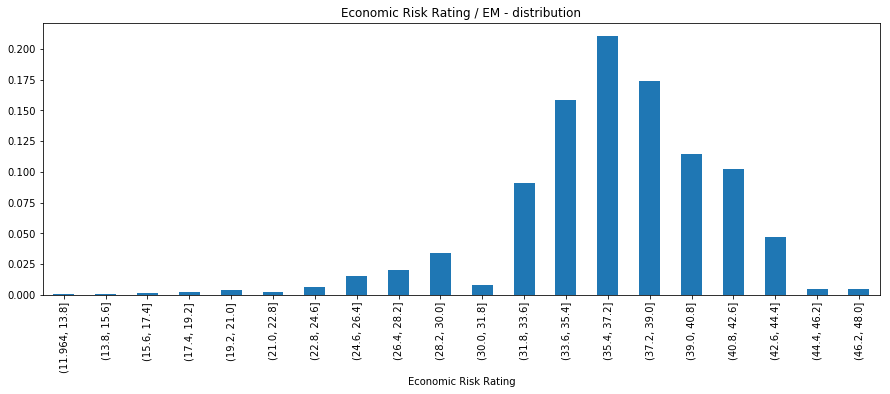

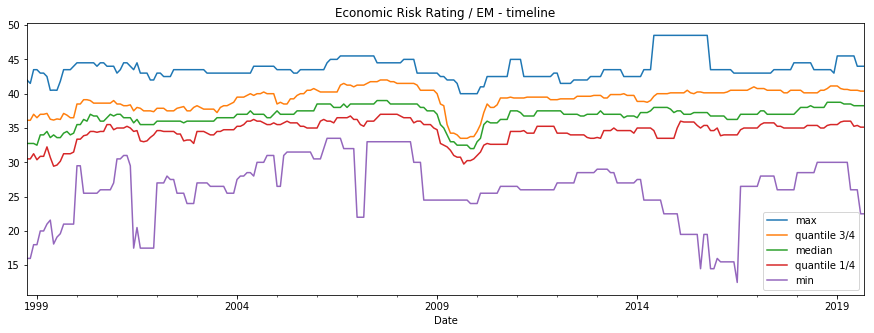

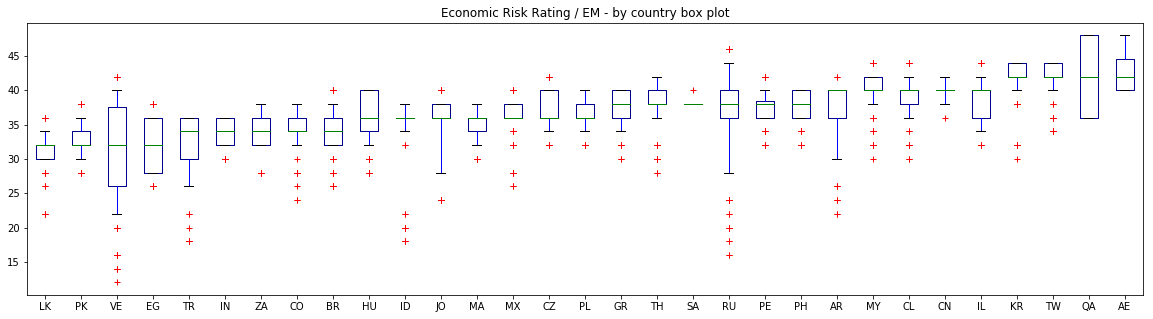

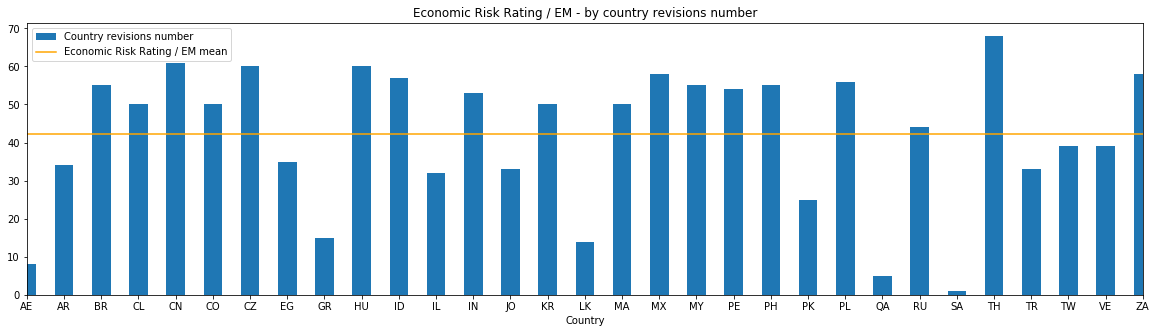

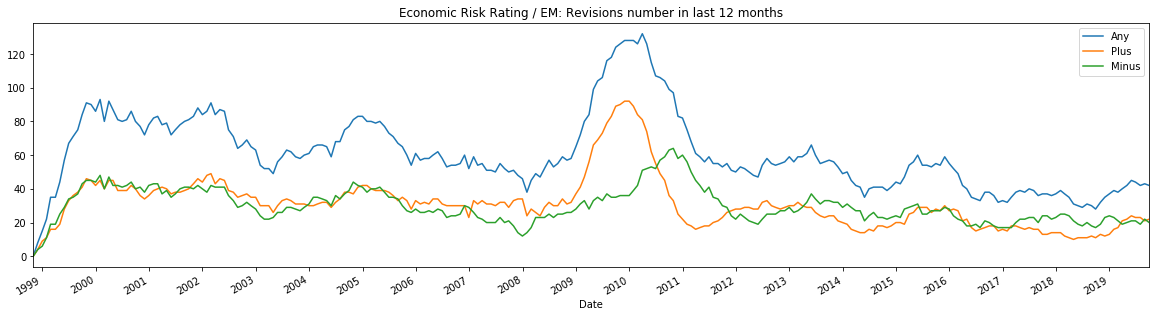

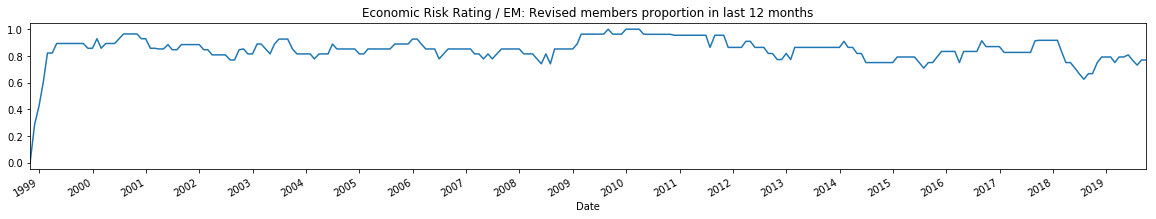

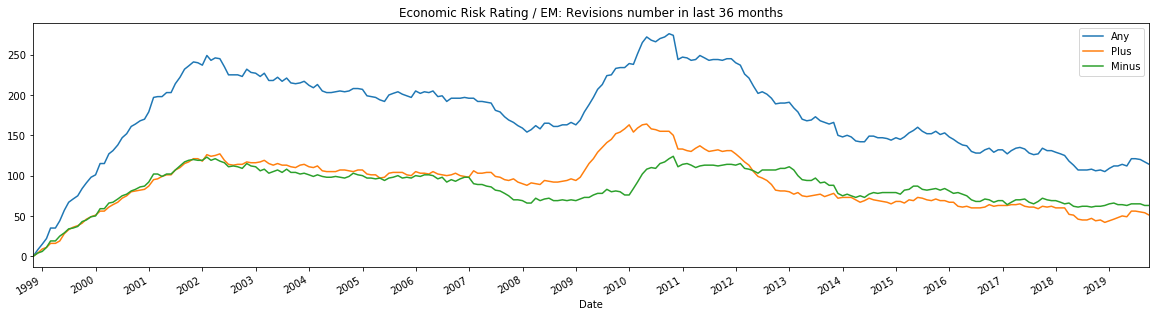

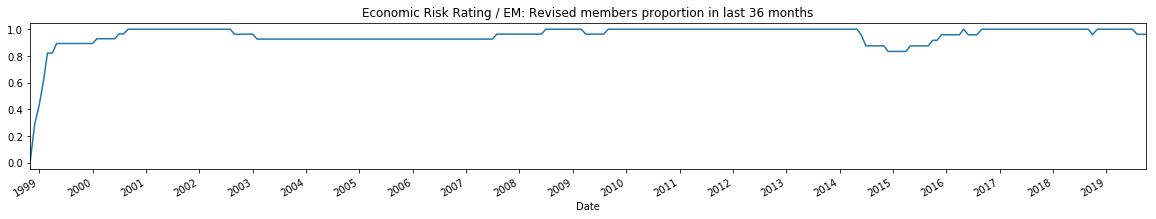

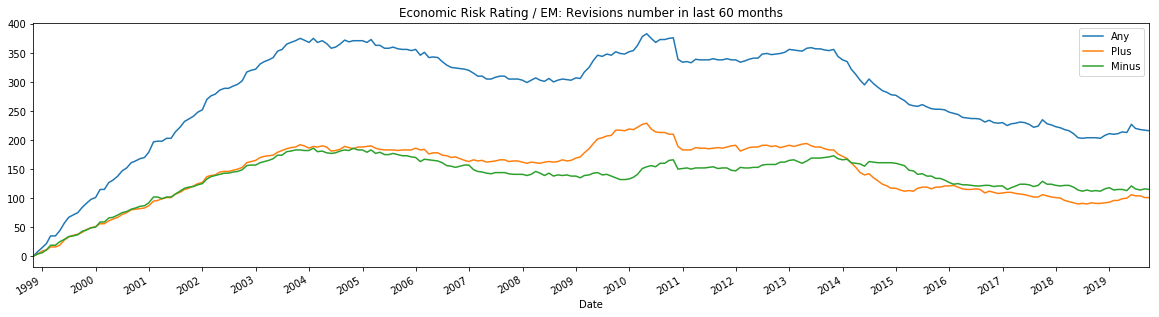

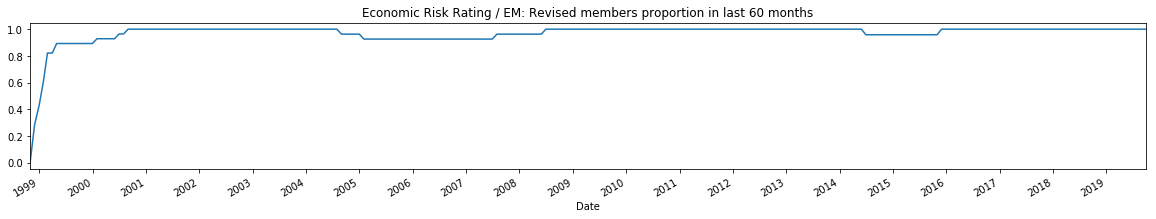

Economic Risk Rating : EM markets ( 6400 ) : Countries covered: 31
Economic Risk Rating : EM markets ( 6400 ) : Average observations per country: 206.45
Economic Risk Rating : EM markets ( 6400 ) : Mean coverage per country: 100.00%
Economic Risk Rating : EM markets ( 6400 ) : Any revisions frequency: 20.42% ( 1307 )
Economic Risk Rating : EM markets ( 6400 ) : Positive revisions frequency: 10.41% ( 666 )
Economic Risk Rating : EM markets ( 6400 ) : Negative revisions frequency: 10.02% ( 641 )
Economic Risk Rating : EM markets ( 6400 ) : Average revisions number for country: 42.16
Economic Risk Rating : EM markets ( 6400 ) : Average stable rating period lentgh (months): 4.89
Economic Risk Rating : EM markets: Mean revision absolute step: 1.23
Economic Risk Rating : EM markets: Mean revision positive step: 1.23
Economic Risk Rating : EM markets: Mean revision negative step: -1.24
Economic Risk Rating : EM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 quantile): 

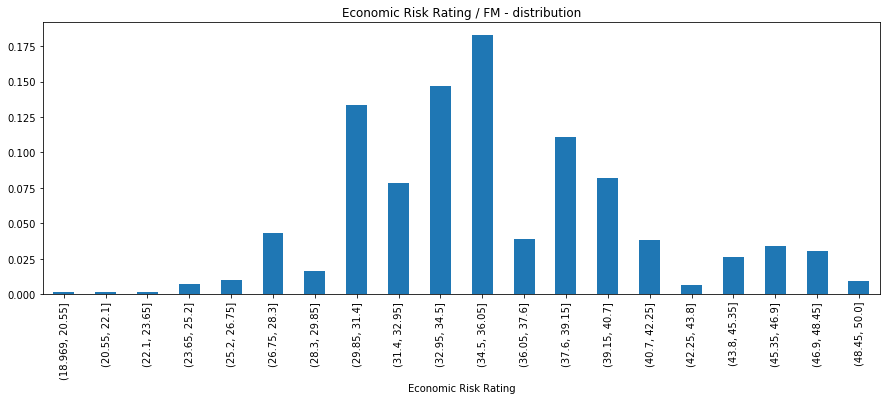

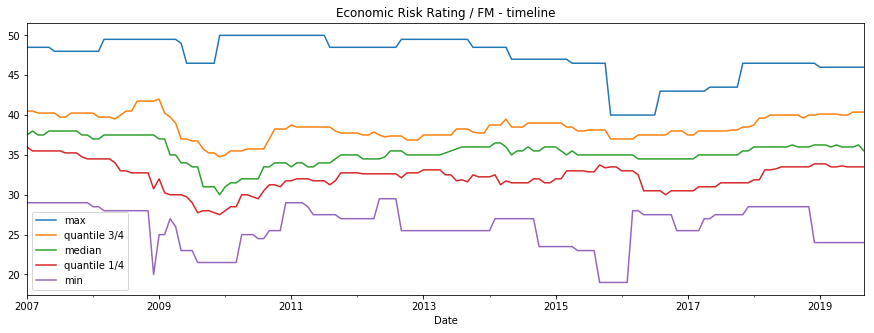

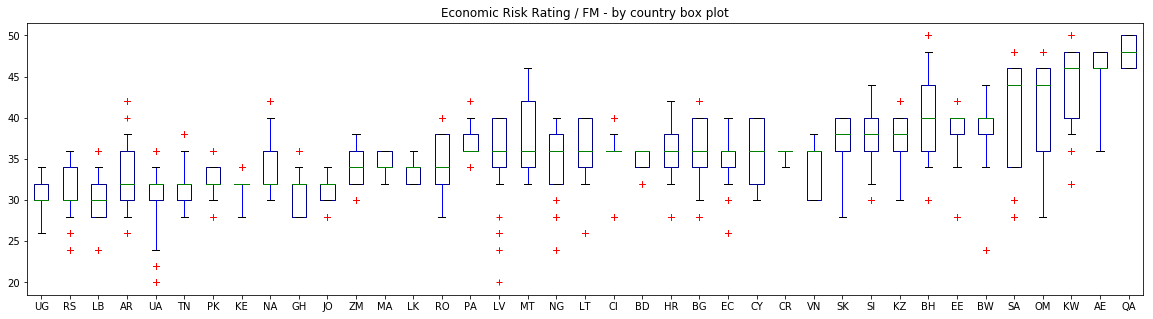

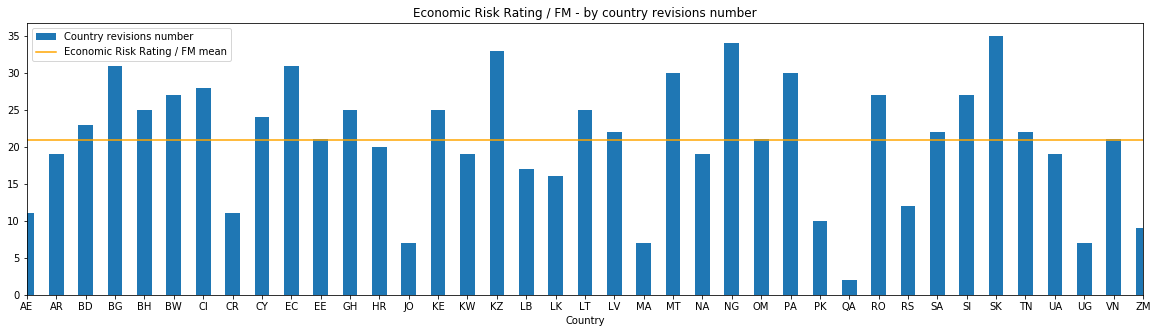

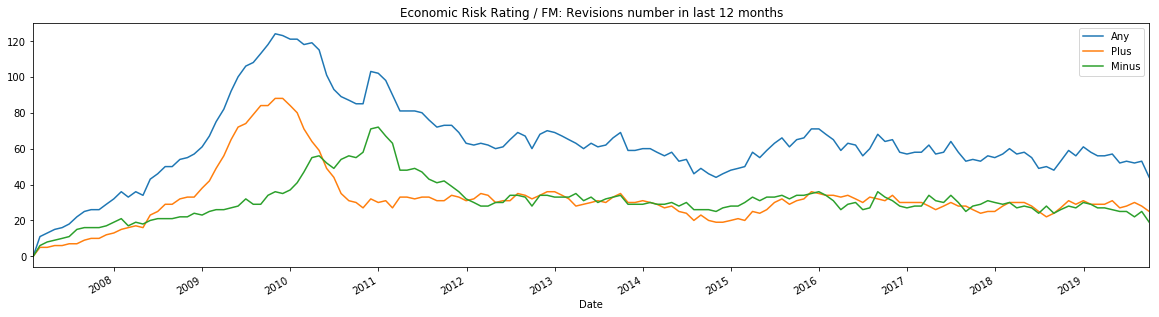

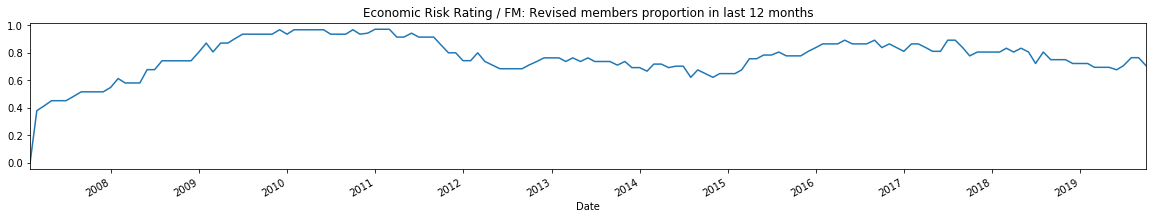

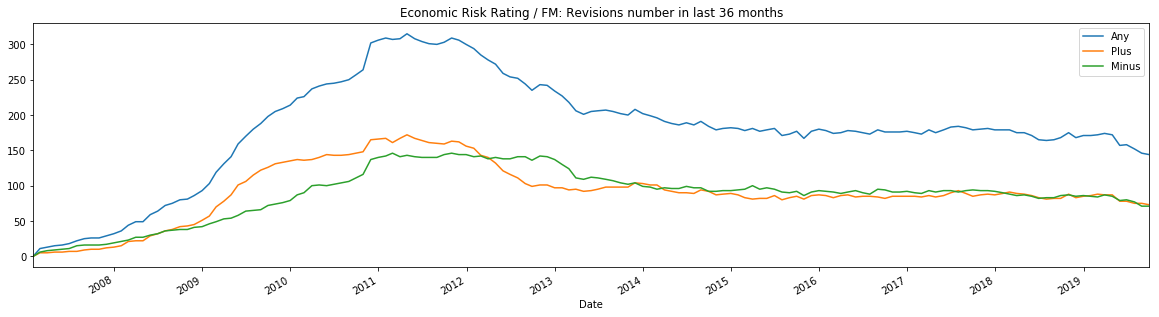

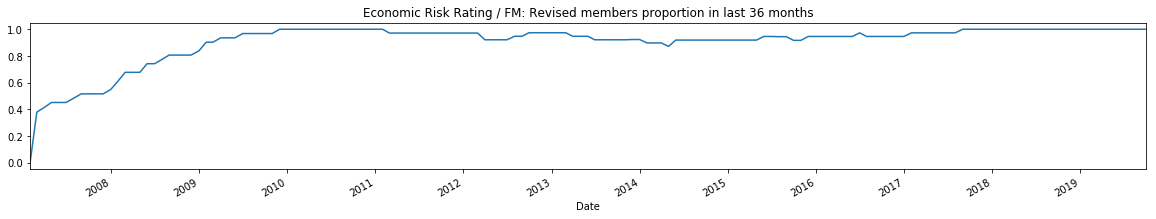

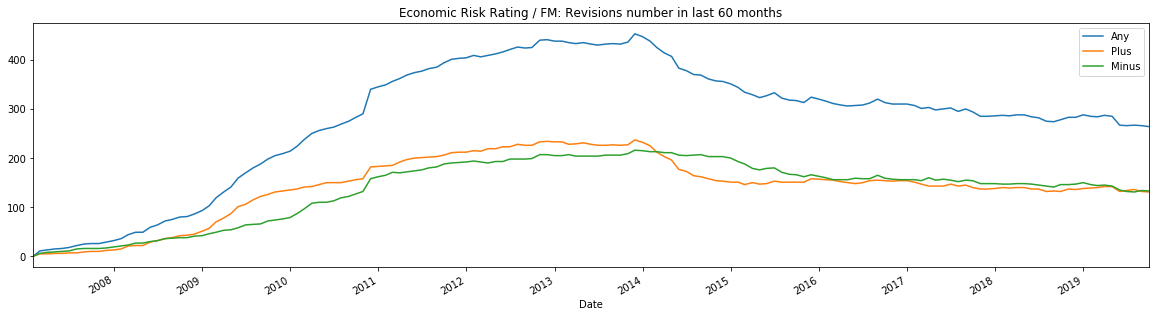

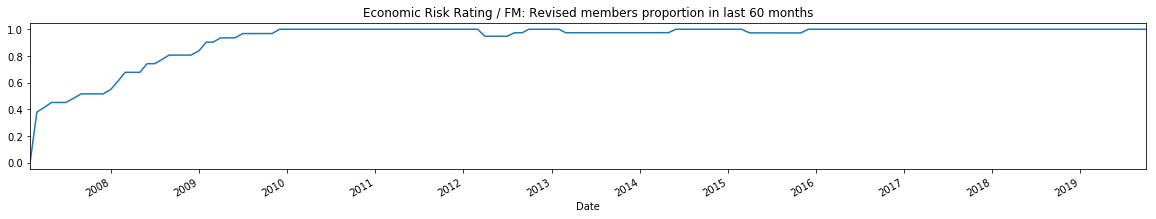

Economic Risk Rating : FM markets ( 5345 ) : Countries covered: 39
Economic Risk Rating : FM markets ( 5345 ) : Average observations per country: 137.05
Economic Risk Rating : FM markets ( 5345 ) : Mean coverage per country: 100.00%
Economic Risk Rating : FM markets ( 5345 ) : Any revisions frequency: 15.23% ( 814 )
Economic Risk Rating : FM markets ( 5345 ) : Positive revisions frequency: 7.78% ( 416 )
Economic Risk Rating : FM markets ( 5345 ) : Negative revisions frequency: 7.45% ( 398 )
Economic Risk Rating : FM markets ( 5345 ) : Average revisions number for country: 20.87
Economic Risk Rating : FM markets ( 5345 ) : Average stable rating period lentgh (months): 6.16
Economic Risk Rating : FM markets: Mean revision absolute step: 1.34
Economic Risk Rating : FM markets: Mean revision positive step: 1.31
Economic Risk Rating : FM markets: Mean revision negative step: -1.36
Economic Risk Rating : FM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 quantile): 12.

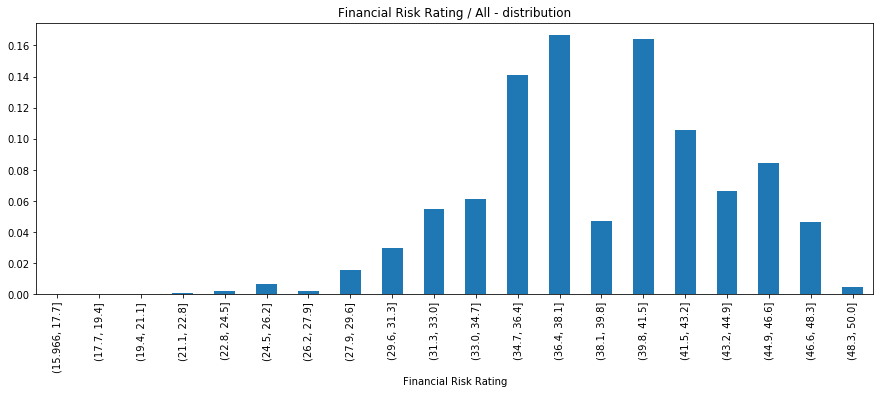

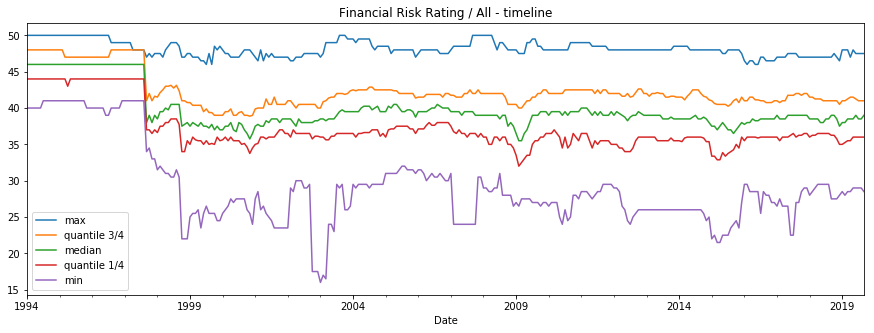

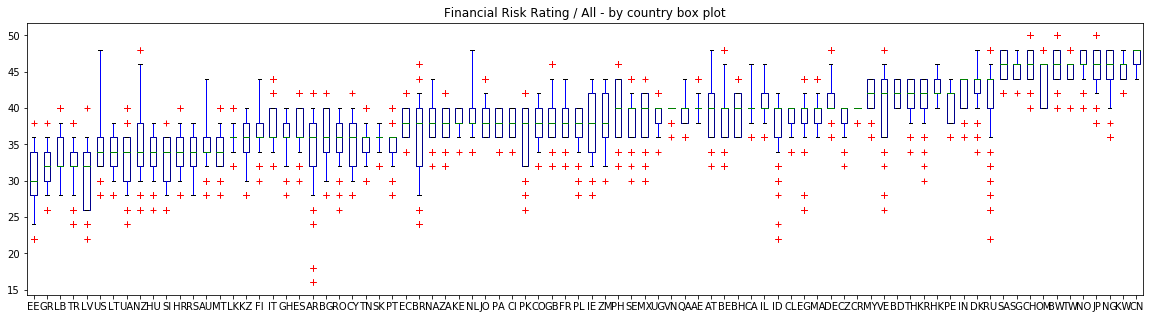

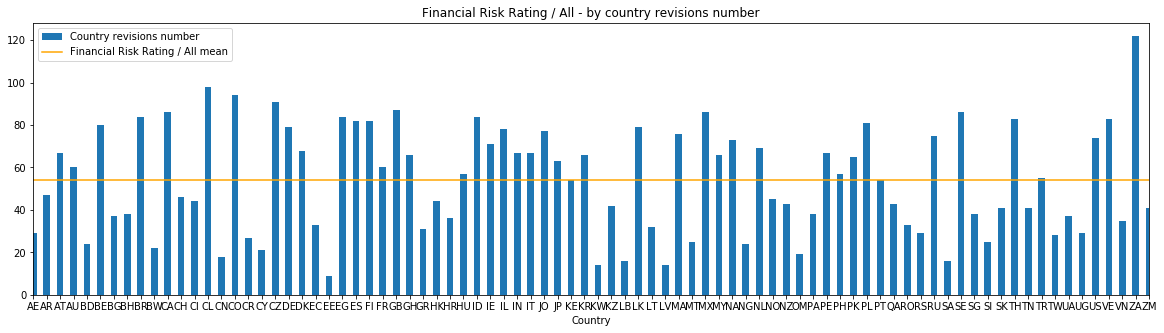

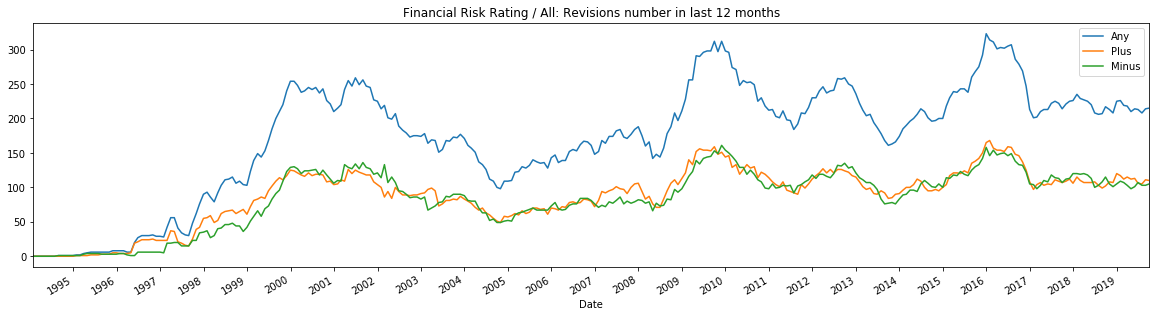

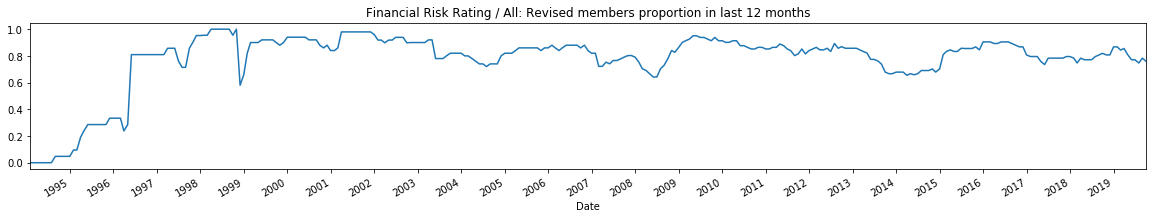

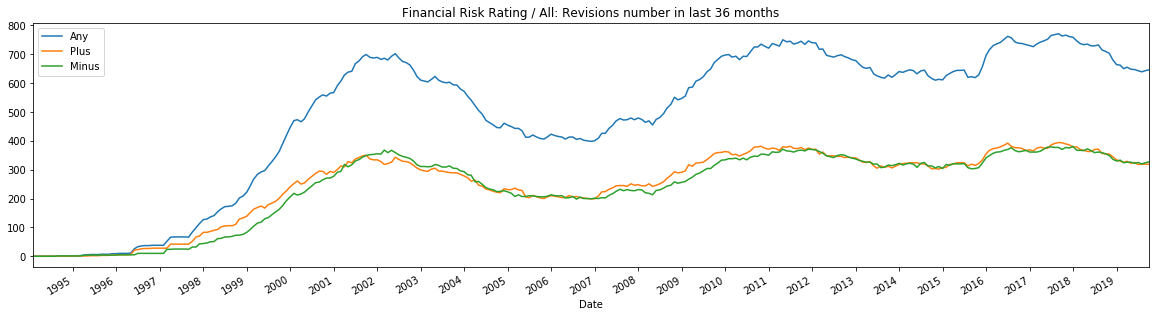

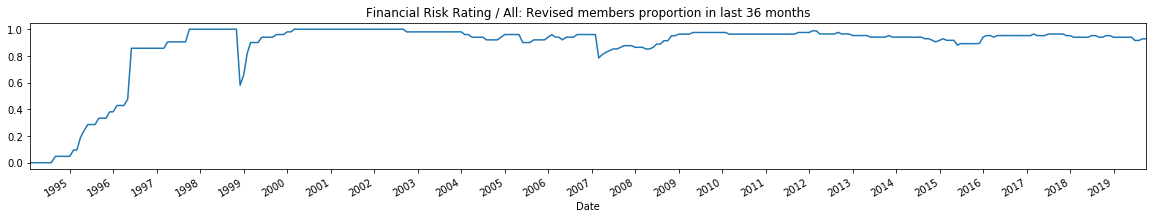

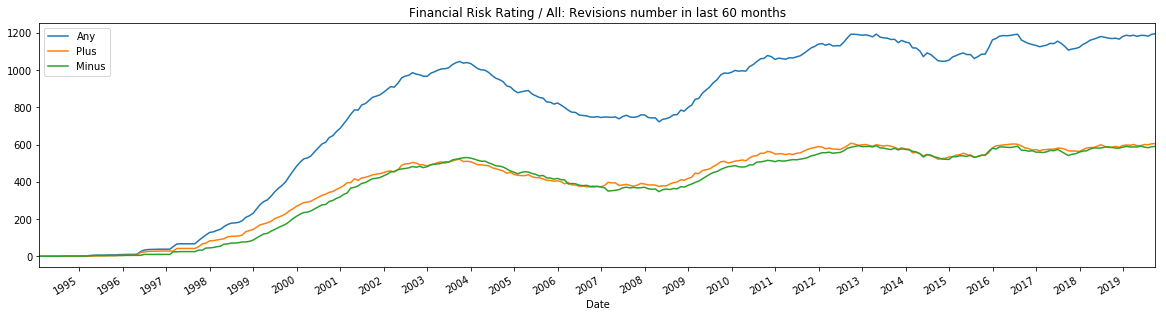

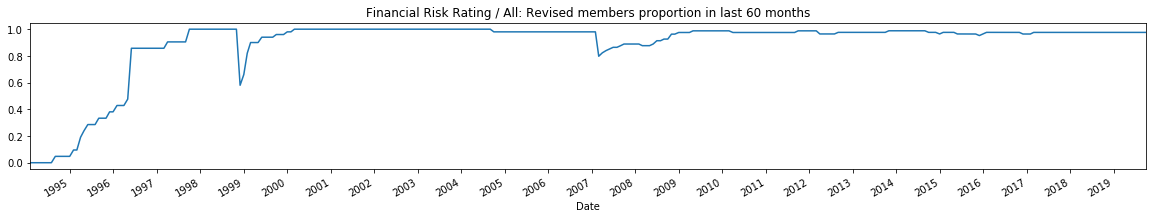

Financial Risk Rating : All markets ( 18758 ) : Countries covered: 84
Financial Risk Rating : All markets ( 18758 ) : Average observations per country: 223.31
Financial Risk Rating : All markets ( 18758 ) : Mean coverage per country: 100.00%
Financial Risk Rating : All markets ( 18758 ) : Any revisions frequency: 24.29% ( 4557 )
Financial Risk Rating : All markets ( 18758 ) : Positive revisions frequency: 12.36% ( 2318 )
Financial Risk Rating : All markets ( 18758 ) : Negative revisions frequency: 11.94% ( 2239 )
Financial Risk Rating : All markets ( 18758 ) : Average revisions number for country: 54.25
Financial Risk Rating : All markets ( 18758 ) : Average stable rating period lentgh (months): 4.04
Financial Risk Rating : All markets: Mean revision absolute step: 1.17
Financial Risk Rating : All markets: Mean revision positive step: 1.17
Financial Risk Rating : All markets: Mean revision negative step: -1.17
Financial Risk Rating : All markets: Mean cross-sectional interquantile rang

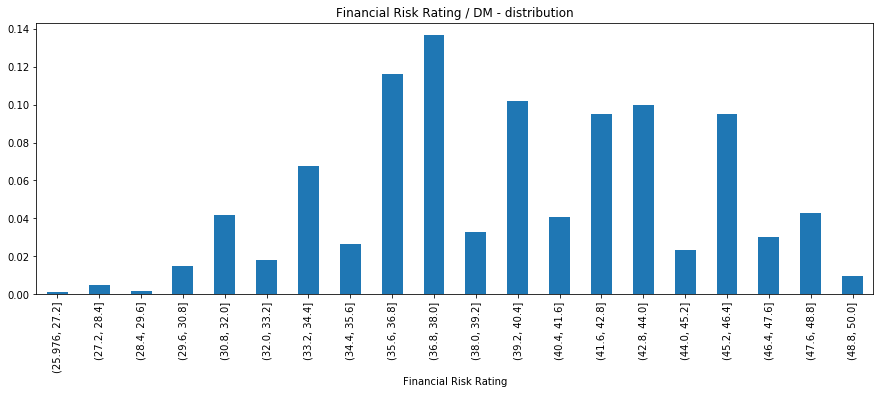

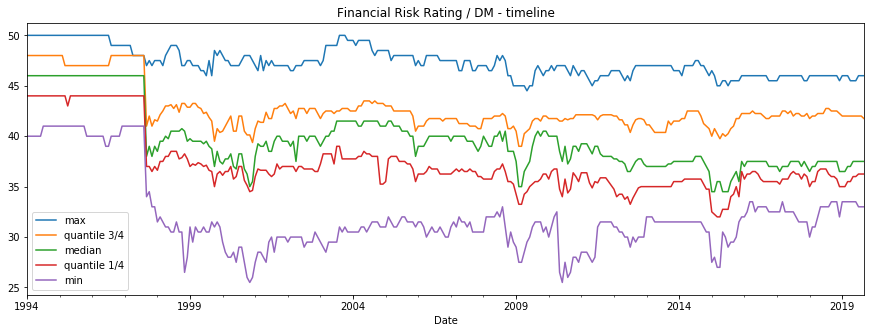

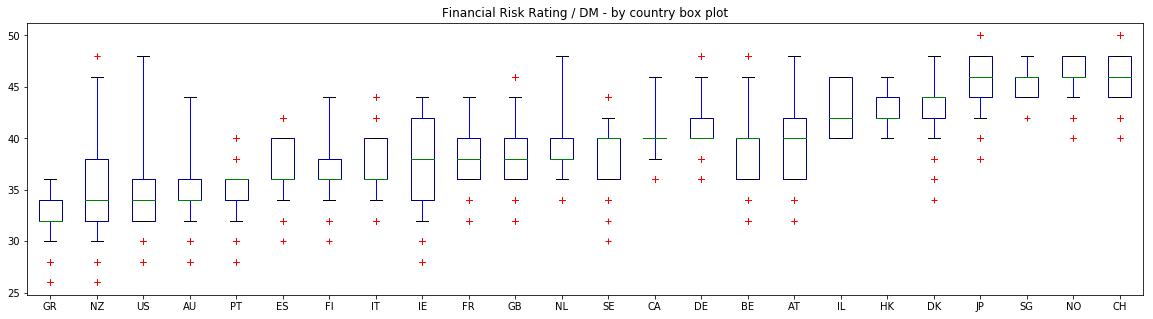

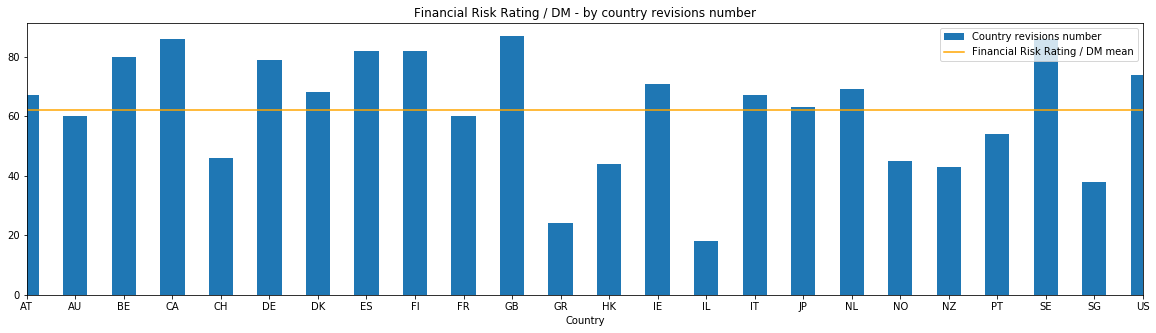

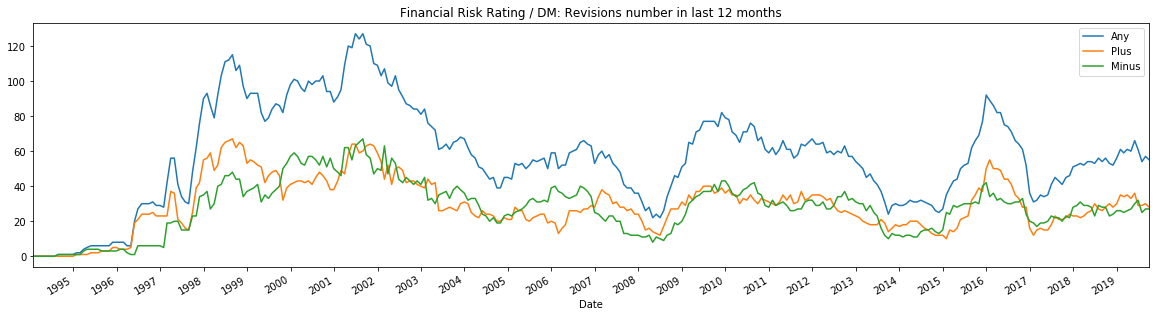

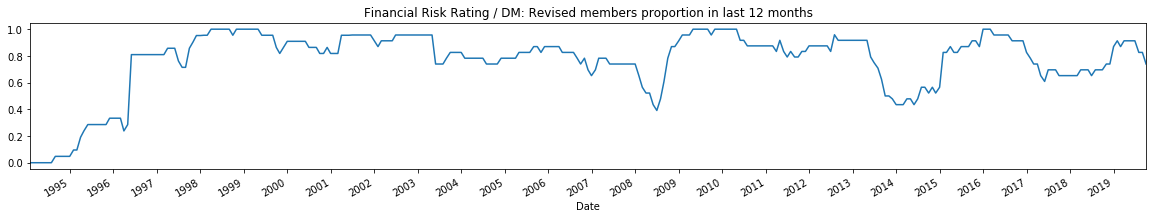

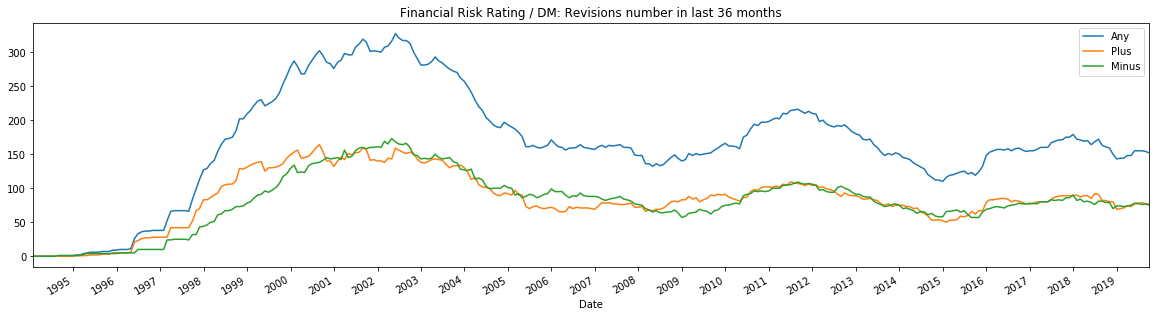

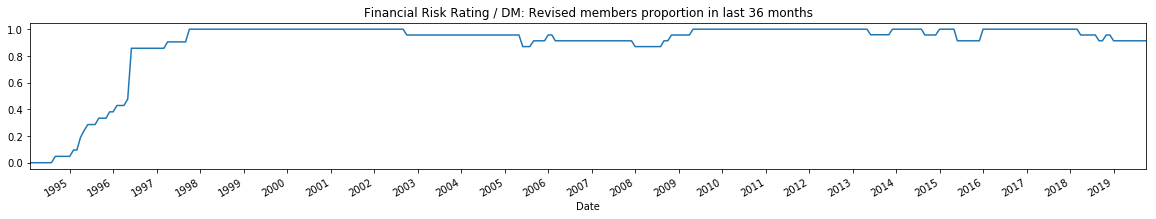

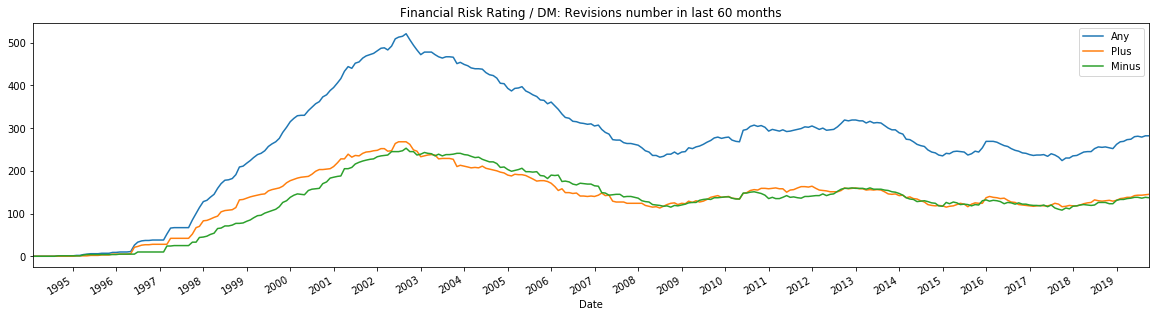

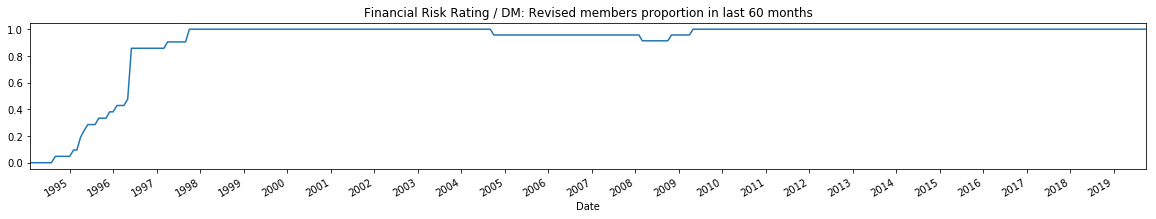

Financial Risk Rating : DM markets ( 7013 ) : Countries covered: 24
Financial Risk Rating : DM markets ( 7013 ) : Average observations per country: 292.21
Financial Risk Rating : DM markets ( 7013 ) : Mean coverage per country: 100.00%
Financial Risk Rating : DM markets ( 7013 ) : Any revisions frequency: 21.29% ( 1493 )
Financial Risk Rating : DM markets ( 7013 ) : Positive revisions frequency: 10.88% ( 763 )
Financial Risk Rating : DM markets ( 7013 ) : Negative revisions frequency: 10.41% ( 730 )
Financial Risk Rating : DM markets ( 7013 ) : Average revisions number for country: 62.21
Financial Risk Rating : DM markets ( 7013 ) : Average stable rating period lentgh (months): 4.6
Financial Risk Rating : DM markets: Mean revision absolute step: 1.15
Financial Risk Rating : DM markets: Mean revision positive step: 1.15
Financial Risk Rating : DM markets: Mean revision negative step: -1.14
Financial Risk Rating : DM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 

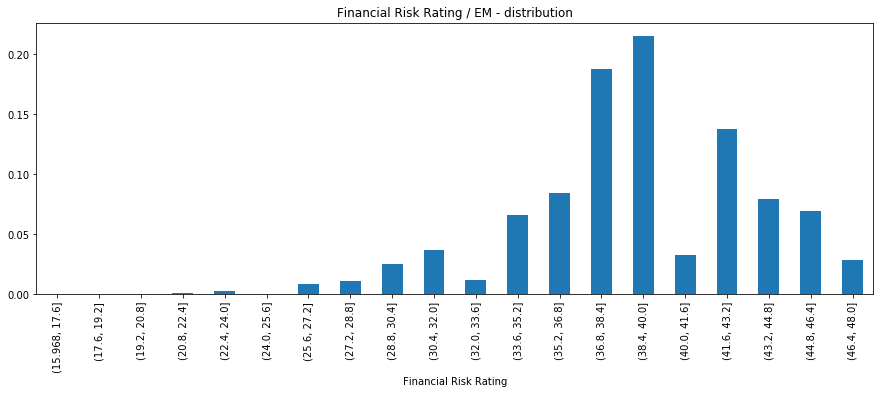

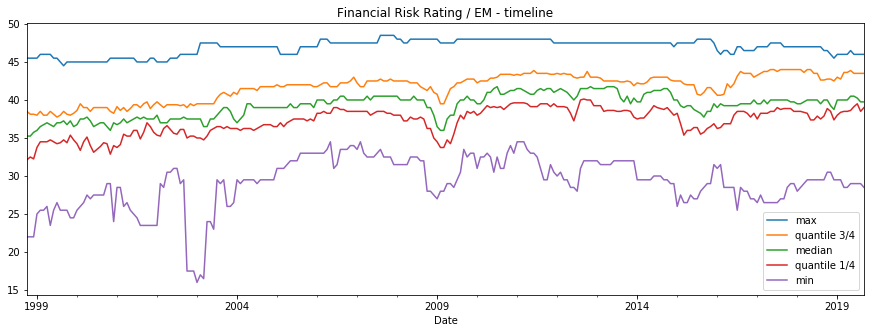

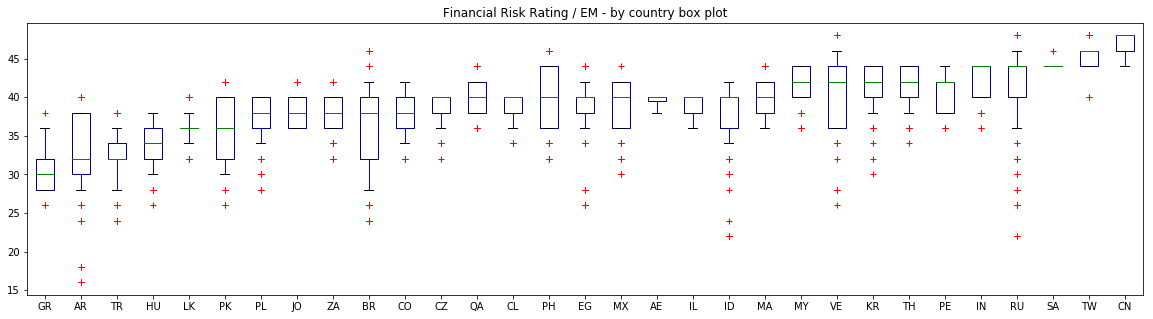

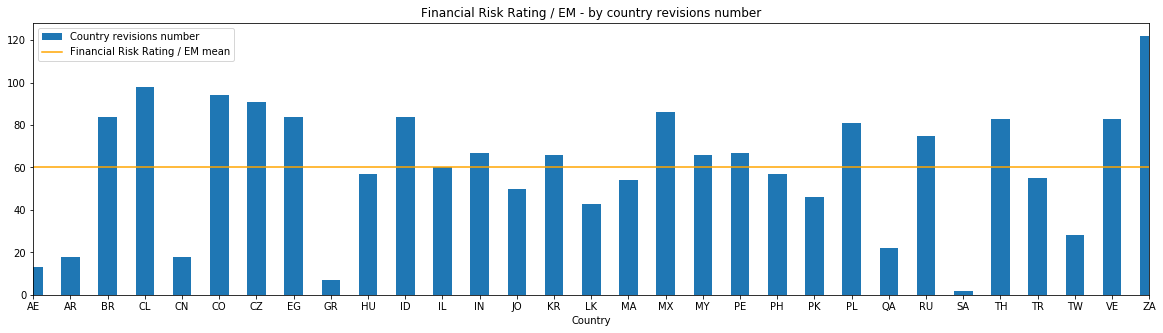

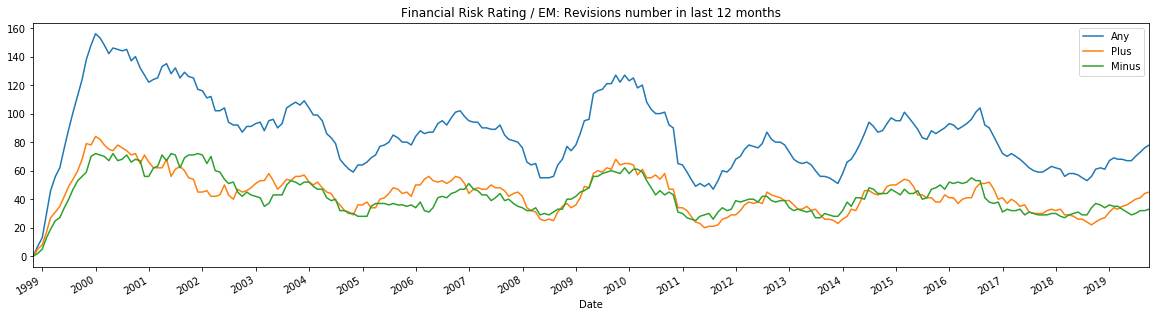

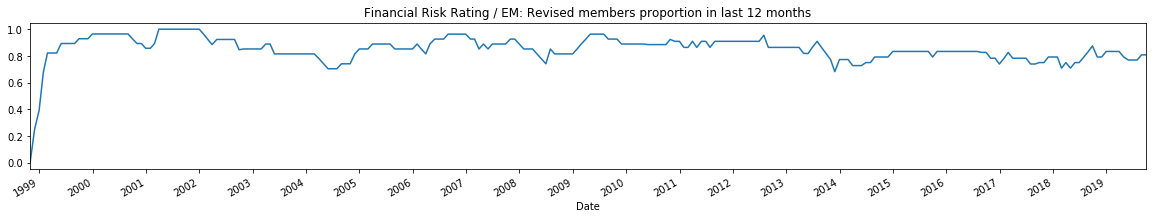

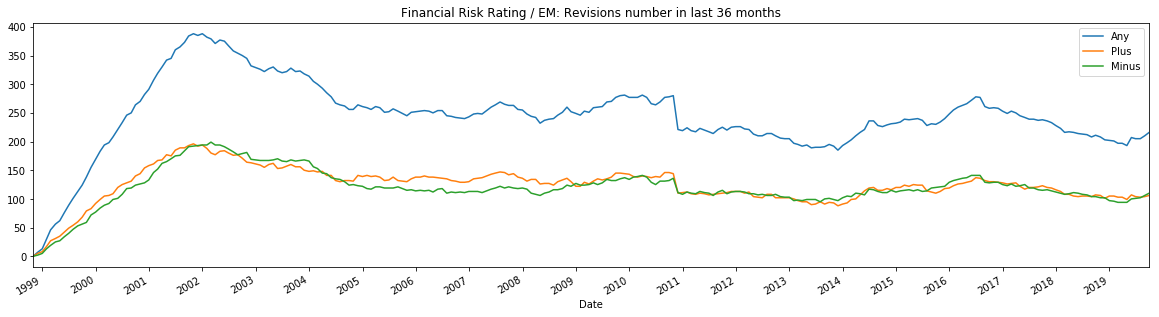

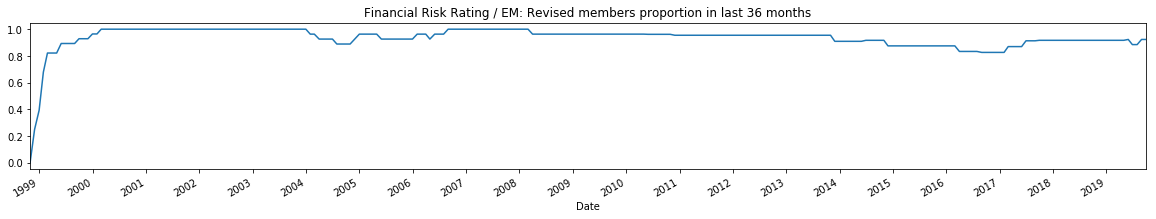

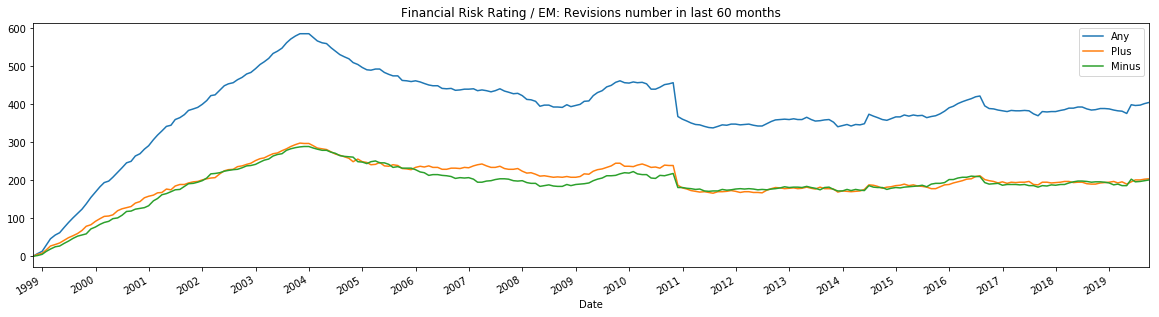

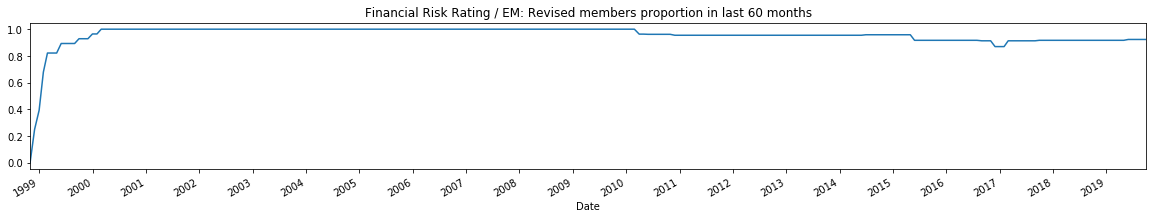

Financial Risk Rating : EM markets ( 6400 ) : Countries covered: 31
Financial Risk Rating : EM markets ( 6400 ) : Average observations per country: 206.45
Financial Risk Rating : EM markets ( 6400 ) : Mean coverage per country: 100.00%
Financial Risk Rating : EM markets ( 6400 ) : Any revisions frequency: 29.08% ( 1861 )
Financial Risk Rating : EM markets ( 6400 ) : Positive revisions frequency: 14.80% ( 947 )
Financial Risk Rating : EM markets ( 6400 ) : Negative revisions frequency: 14.28% ( 914 )
Financial Risk Rating : EM markets ( 6400 ) : Average revisions number for country: 60.03
Financial Risk Rating : EM markets ( 6400 ) : Average stable rating period lentgh (months): 3.43
Financial Risk Rating : EM markets: Mean revision absolute step: 1.19
Financial Risk Rating : EM markets: Mean revision positive step: 1.2
Financial Risk Rating : EM markets: Mean revision negative step: -1.18
Financial Risk Rating : EM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 

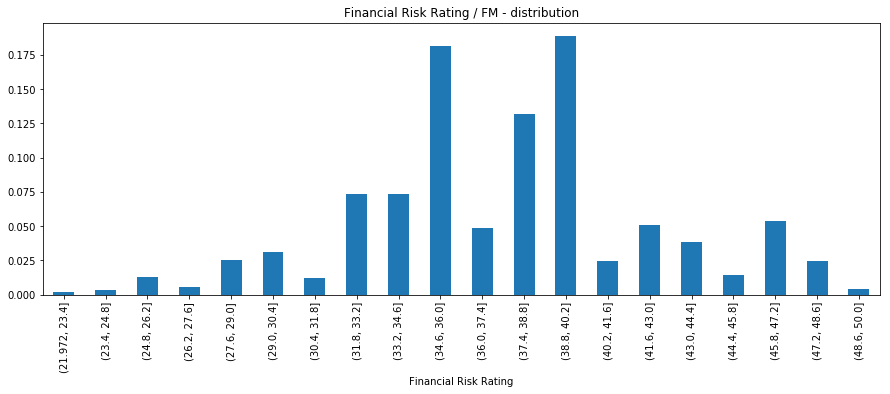

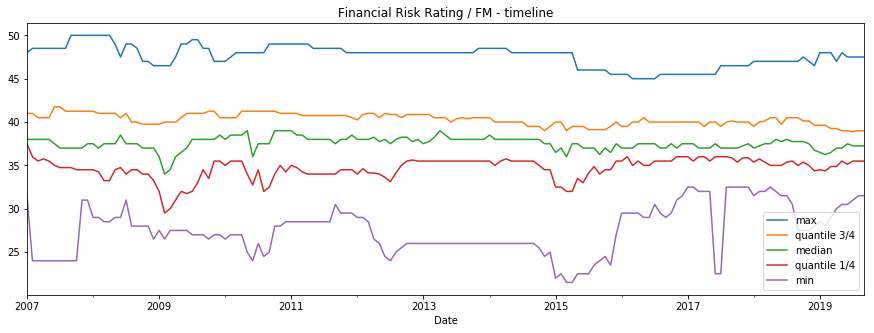

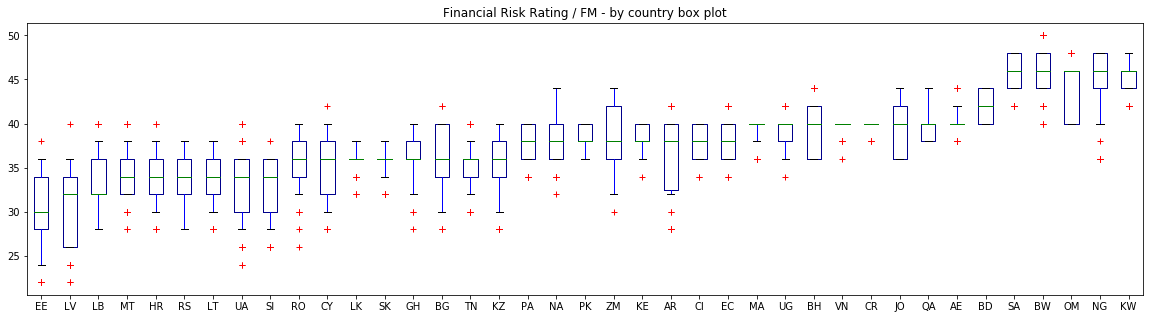

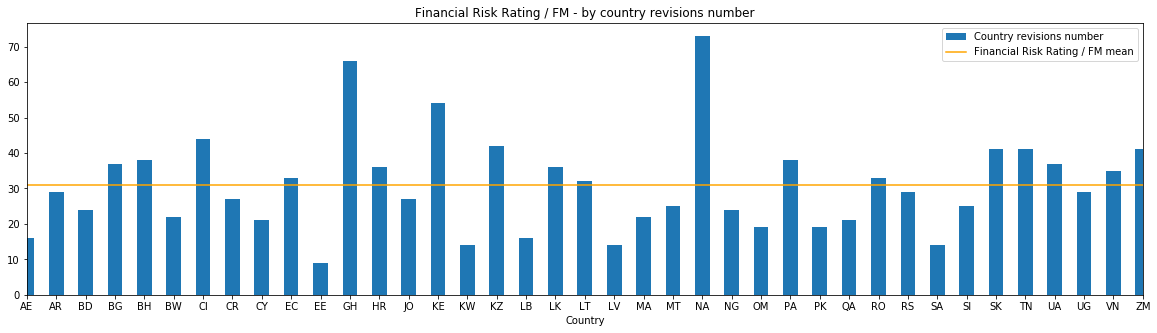

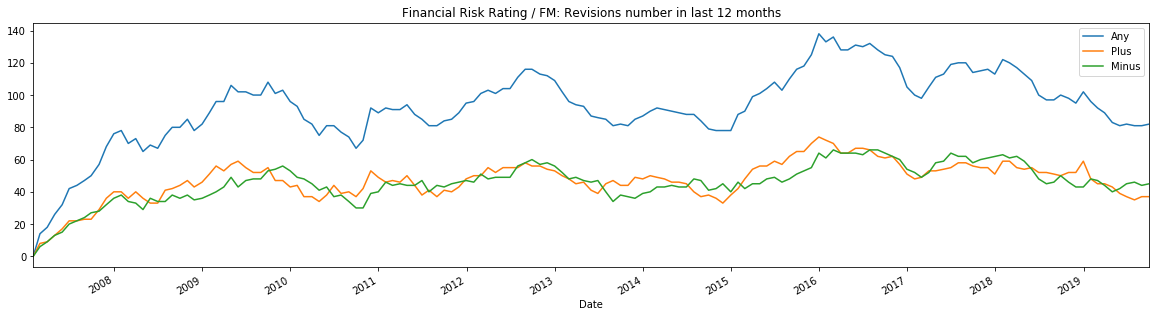

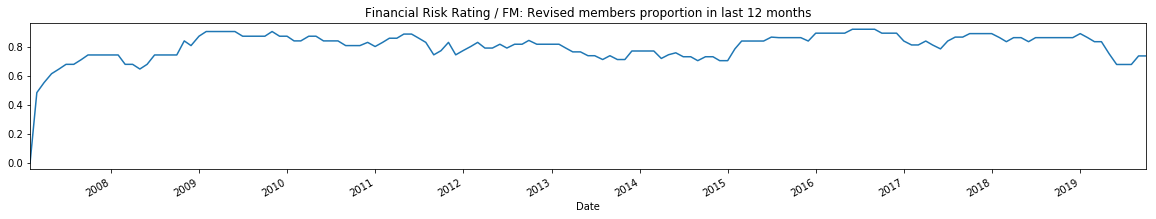

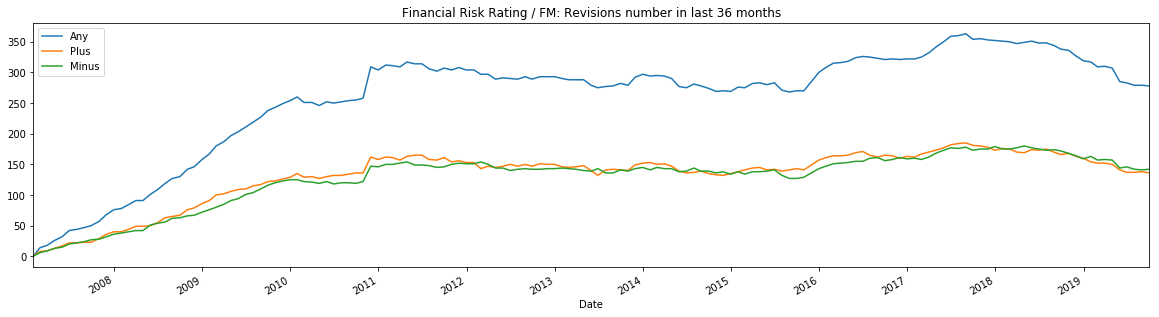

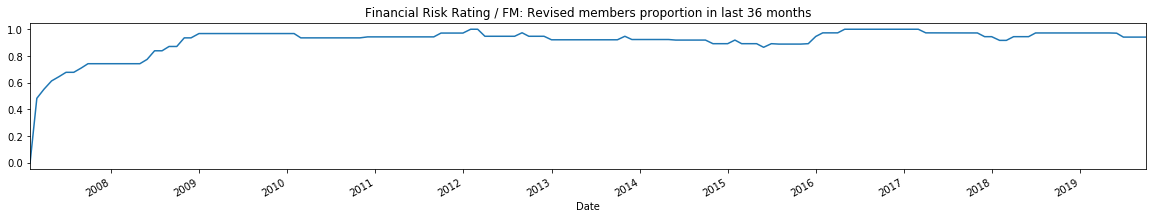

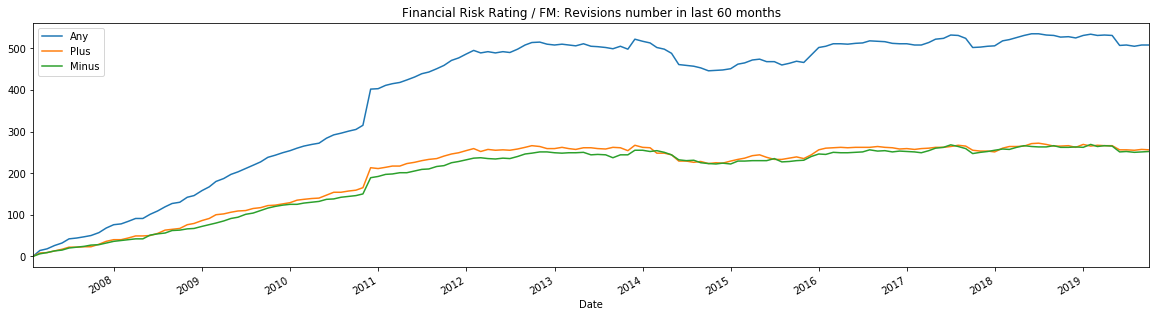

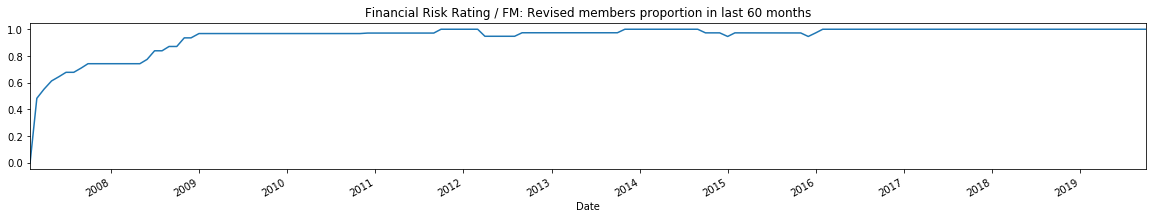

Financial Risk Rating : FM markets ( 5345 ) : Countries covered: 39
Financial Risk Rating : FM markets ( 5345 ) : Average observations per country: 137.05
Financial Risk Rating : FM markets ( 5345 ) : Mean coverage per country: 100.00%
Financial Risk Rating : FM markets ( 5345 ) : Any revisions frequency: 22.51% ( 1203 )
Financial Risk Rating : FM markets ( 5345 ) : Positive revisions frequency: 11.38% ( 608 )
Financial Risk Rating : FM markets ( 5345 ) : Negative revisions frequency: 11.13% ( 595 )
Financial Risk Rating : FM markets ( 5345 ) : Average revisions number for country: 30.85
Financial Risk Rating : FM markets ( 5345 ) : Average stable rating period lentgh (months): 4.29
Financial Risk Rating : FM markets: Mean revision absolute step: 1.17
Financial Risk Rating : FM markets: Mean revision positive step: 1.15
Financial Risk Rating : FM markets: Mean revision negative step: -1.2
Financial Risk Rating : FM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 

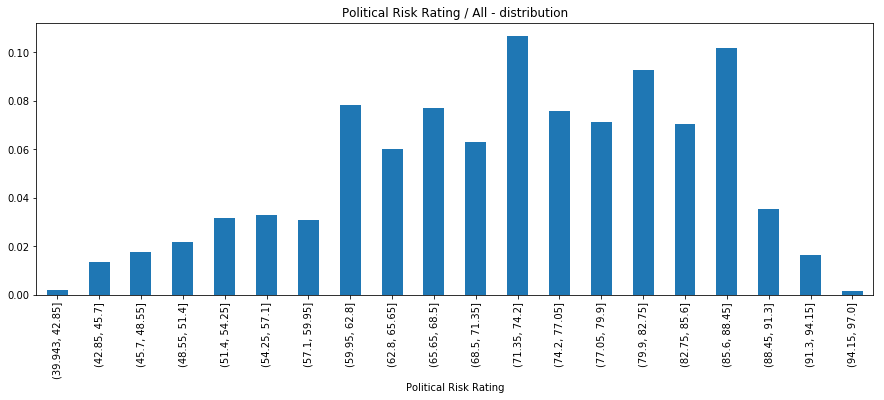

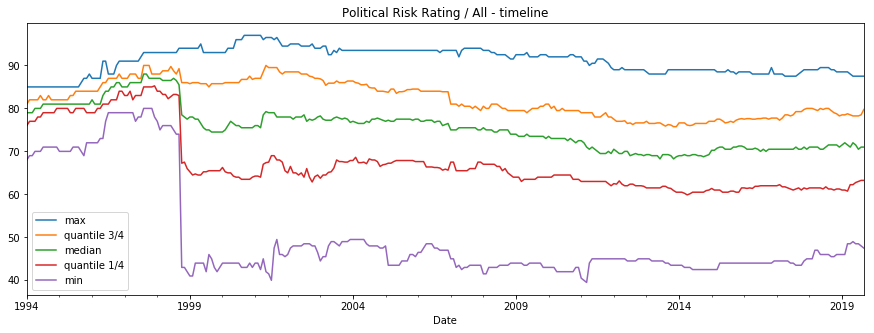

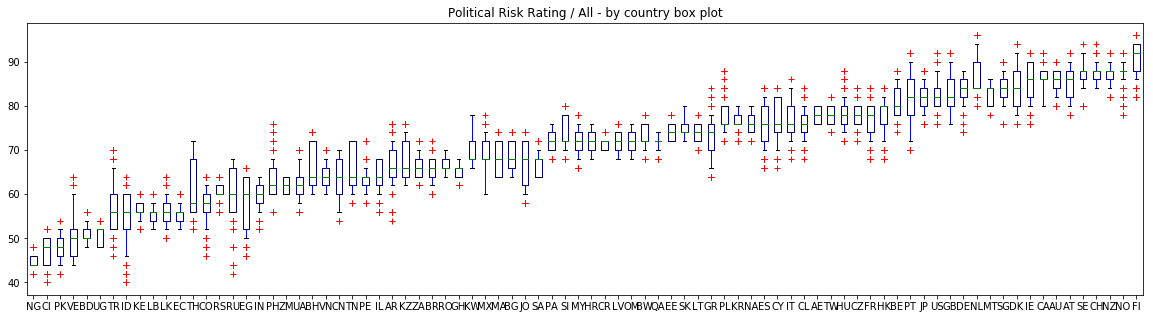

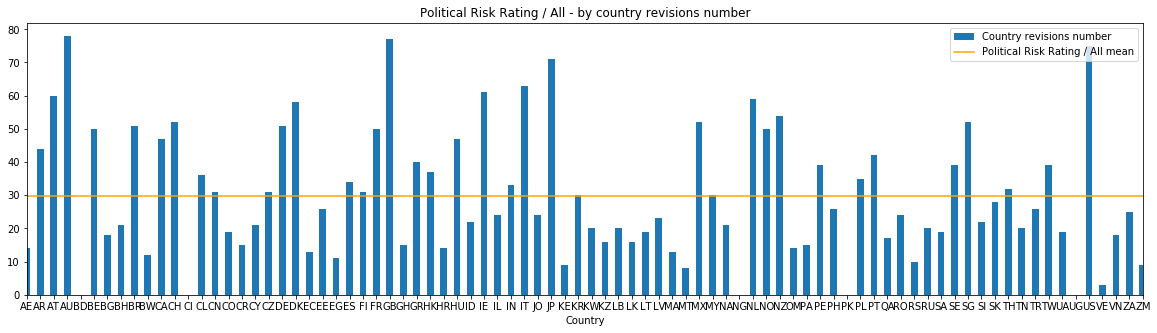

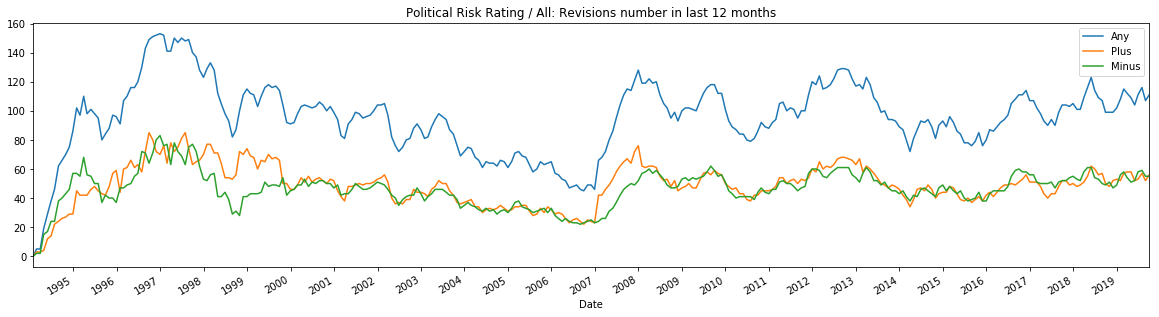

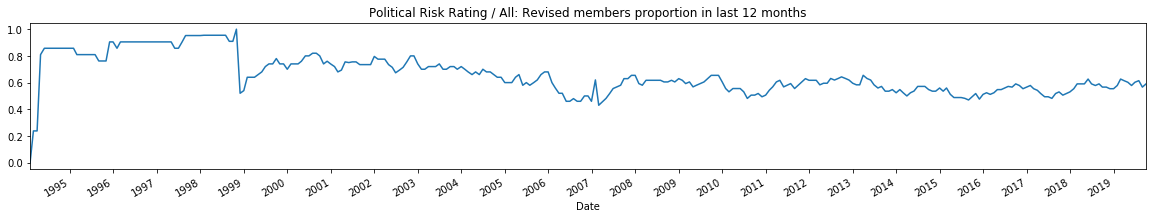

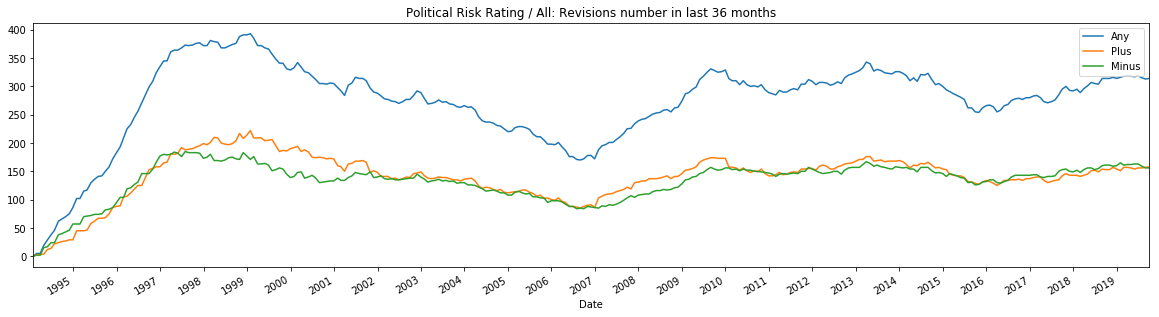

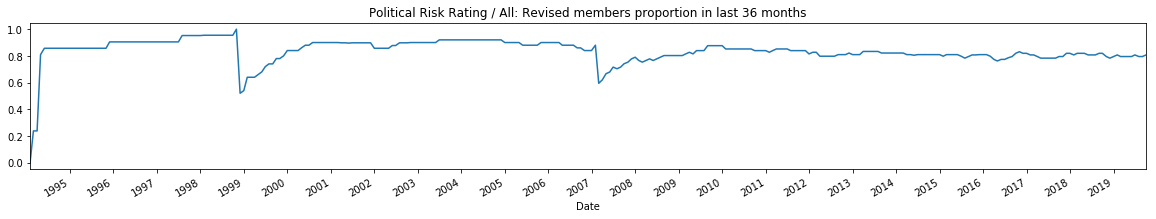

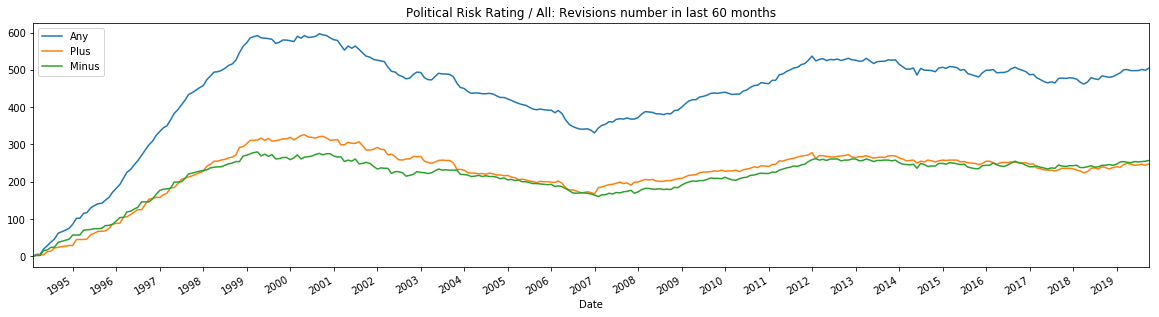

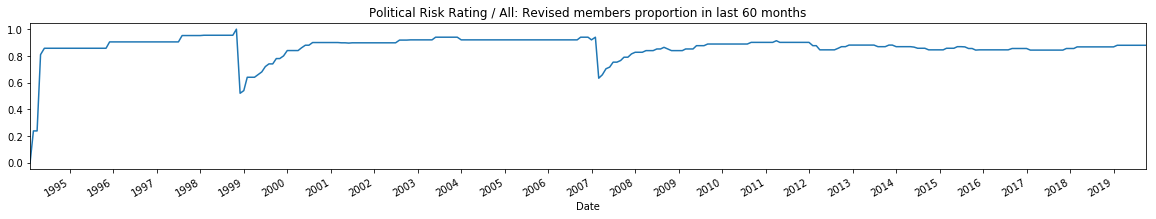

Political Risk Rating : All markets ( 18758 ) : Countries covered: 84
Political Risk Rating : All markets ( 18758 ) : Average observations per country: 223.31
Political Risk Rating : All markets ( 18758 ) : Mean coverage per country: 100.00%
Political Risk Rating : All markets ( 18758 ) : Any revisions frequency: 13.38% ( 2510 )
Political Risk Rating : All markets ( 18758 ) : Positive revisions frequency: 6.87% ( 1289 )
Political Risk Rating : All markets ( 18758 ) : Negative revisions frequency: 6.51% ( 1221 )
Political Risk Rating : All markets ( 18758 ) : Average revisions number for country: 29.88
Political Risk Rating : All markets ( 18758 ) : Average stable rating period lentgh (months): 7.23
Political Risk Rating : All markets: Mean revision absolute step: 1.09
Political Risk Rating : All markets: Mean revision positive step: 1.1
Political Risk Rating : All markets: Mean revision negative step: -1.07
Political Risk Rating : All markets: Mean cross-sectional interquantile range (

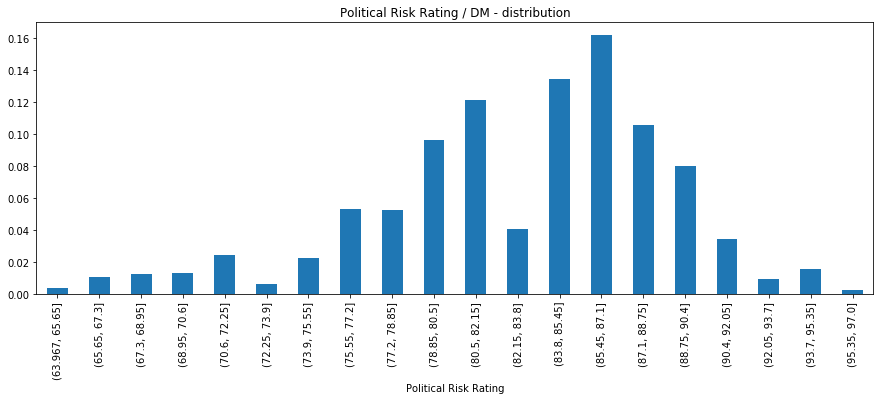

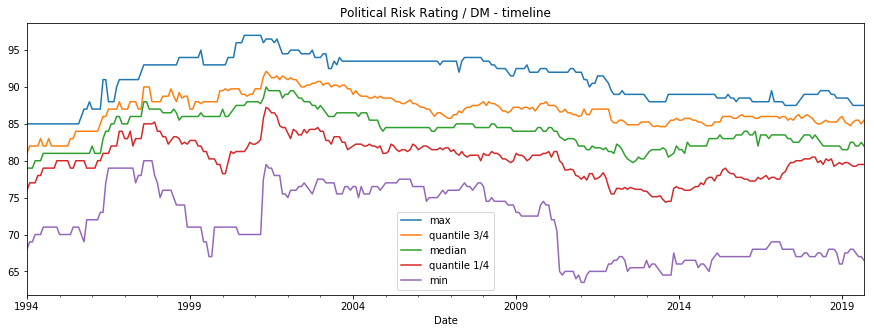

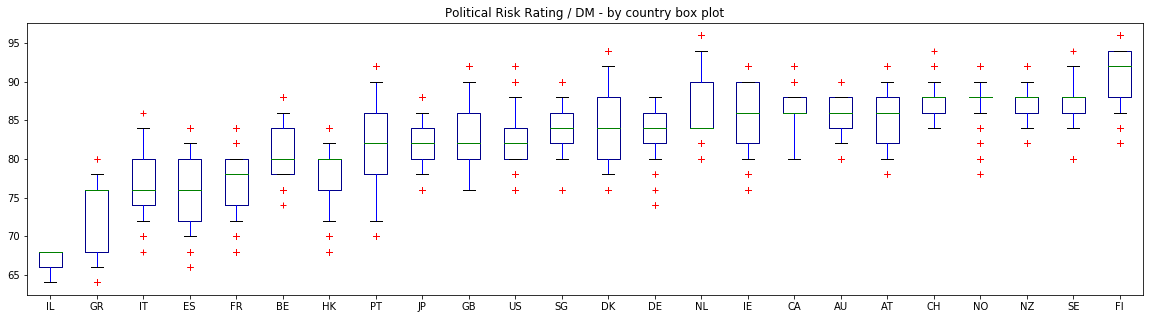

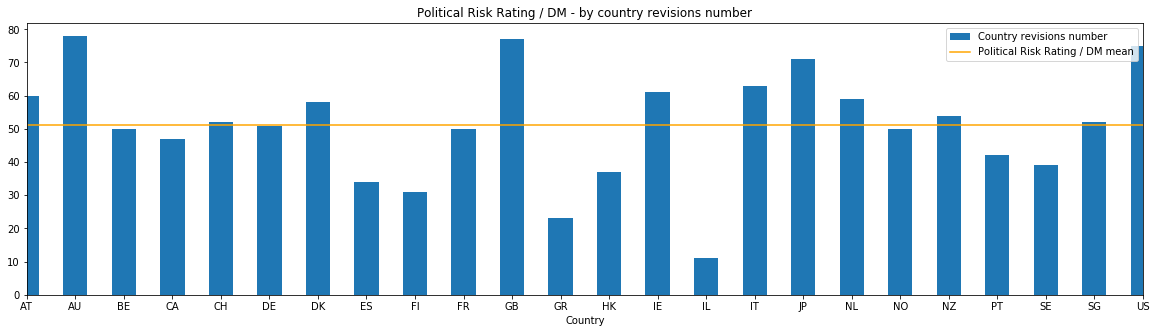

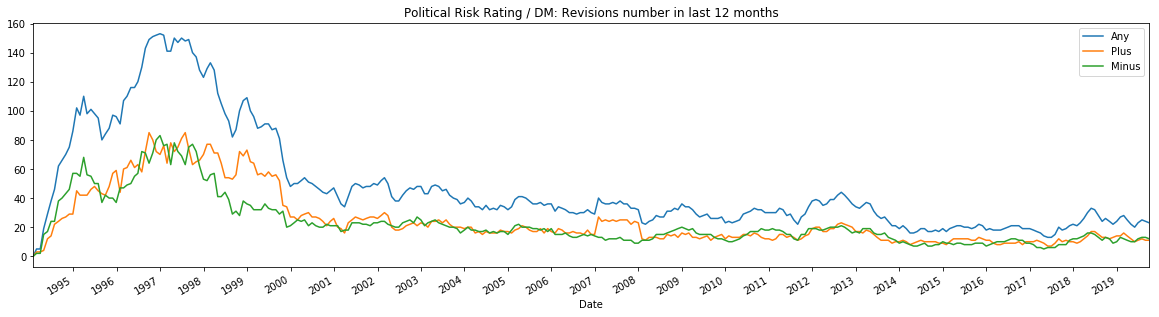

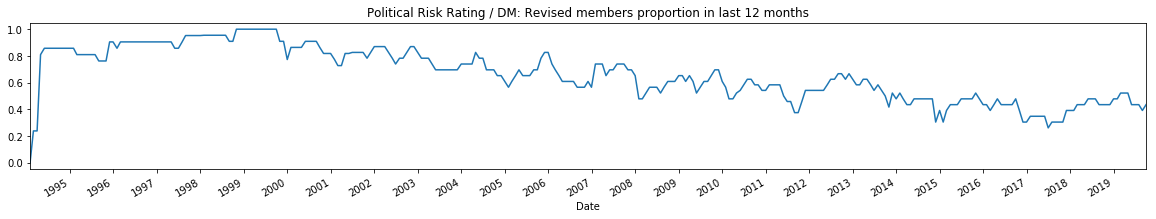

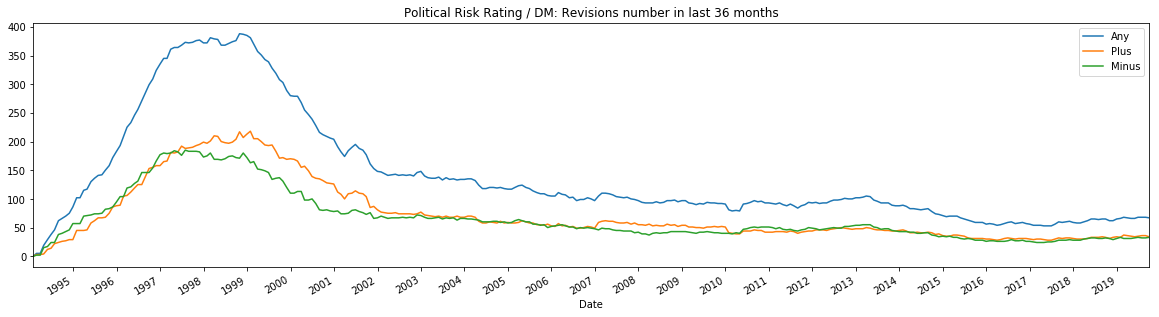

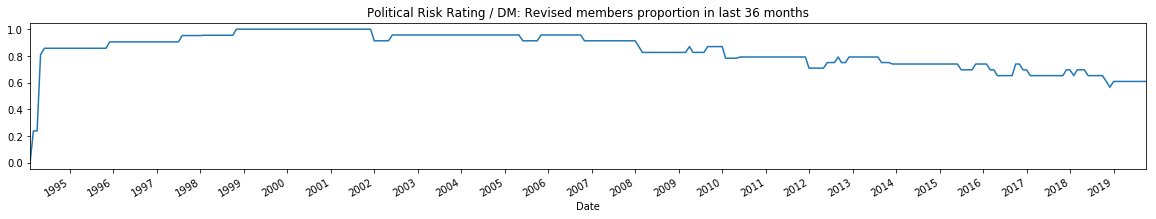

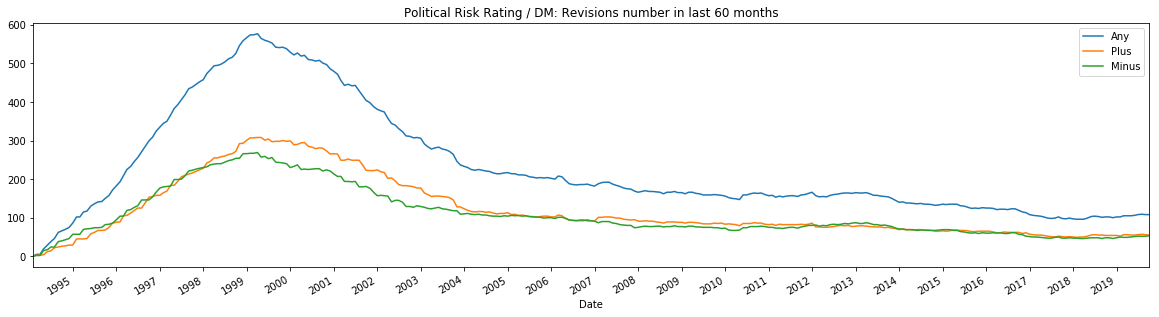

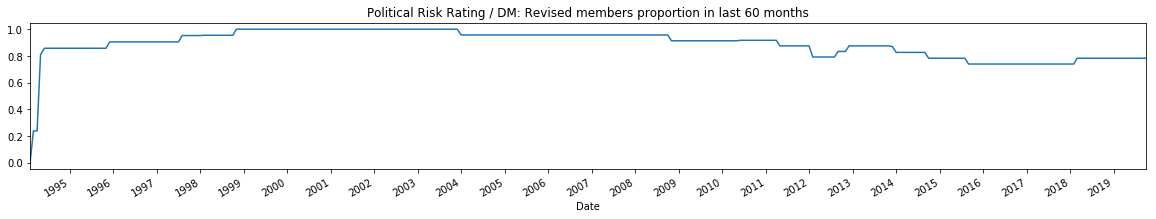

Political Risk Rating : DM markets ( 7013 ) : Countries covered: 24
Political Risk Rating : DM markets ( 7013 ) : Average observations per country: 292.21
Political Risk Rating : DM markets ( 7013 ) : Mean coverage per country: 100.00%
Political Risk Rating : DM markets ( 7013 ) : Any revisions frequency: 17.47% ( 1225 )
Political Risk Rating : DM markets ( 7013 ) : Positive revisions frequency: 9.15% ( 642 )
Political Risk Rating : DM markets ( 7013 ) : Negative revisions frequency: 8.31% ( 583 )
Political Risk Rating : DM markets ( 7013 ) : Average revisions number for country: 51.04
Political Risk Rating : DM markets ( 7013 ) : Average stable rating period lentgh (months): 5.63
Political Risk Rating : DM markets: Mean revision absolute step: 1.17
Political Risk Rating : DM markets: Mean revision positive step: 1.19
Political Risk Rating : DM markets: Mean revision negative step: -1.14
Political Risk Rating : DM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 q

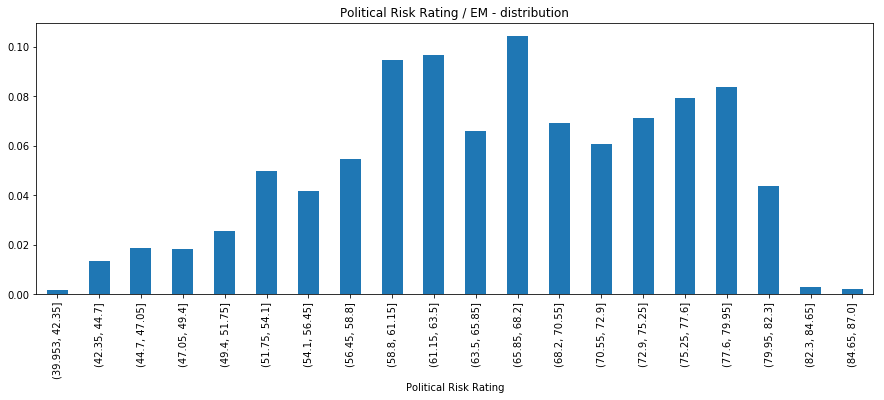

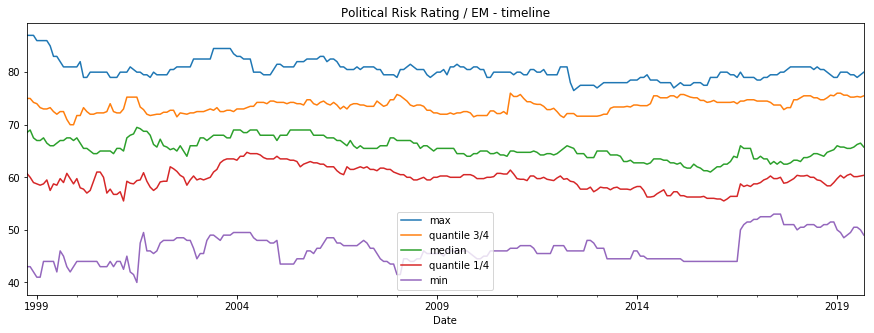

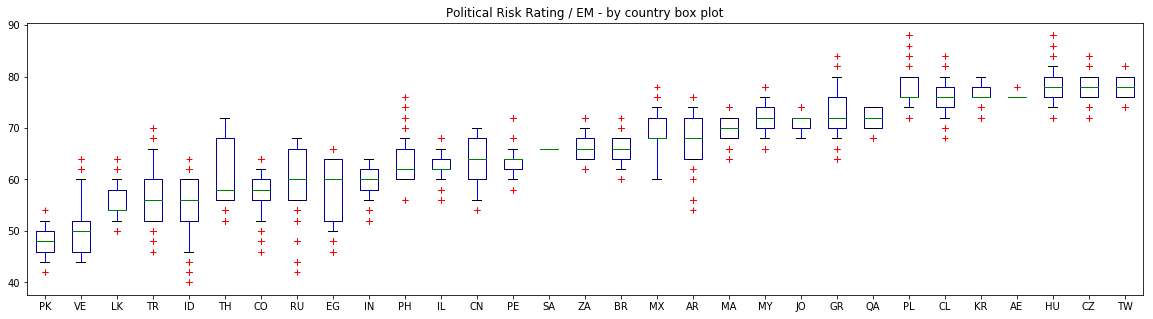

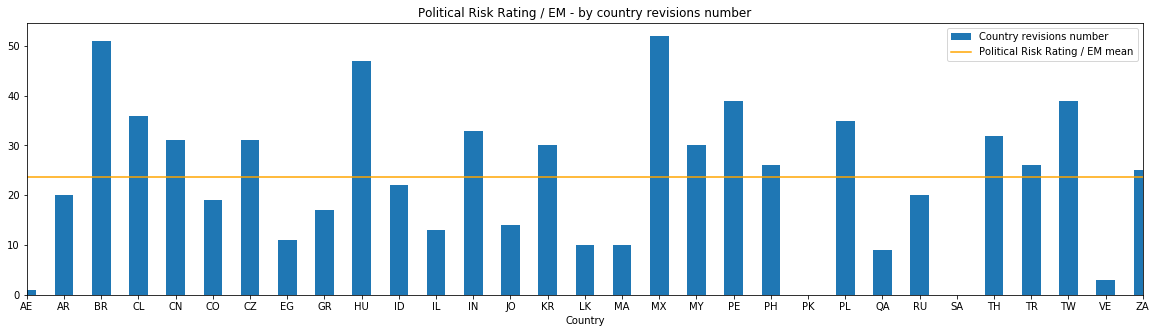

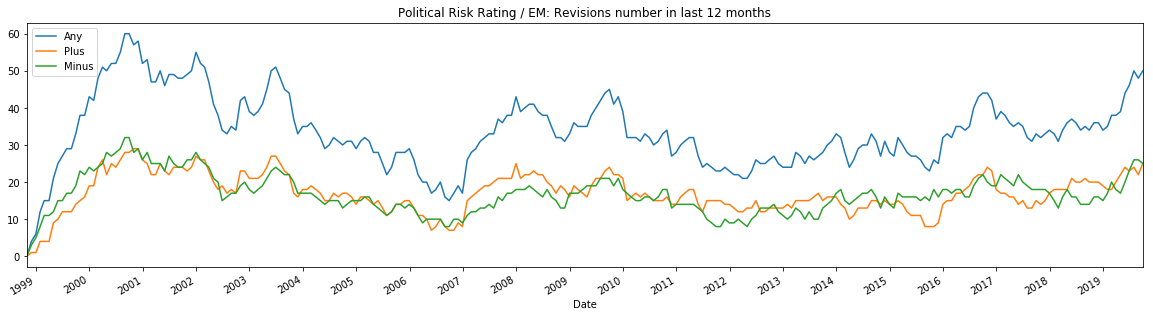

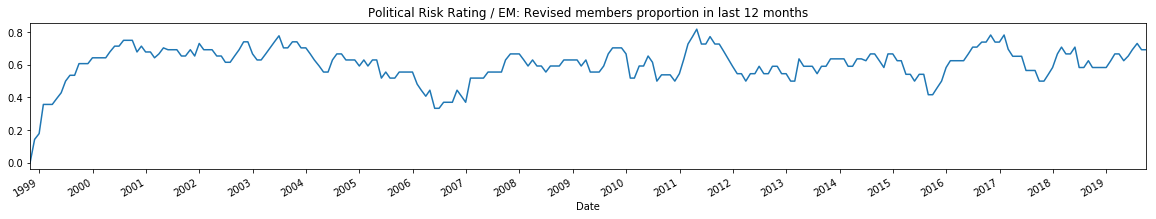

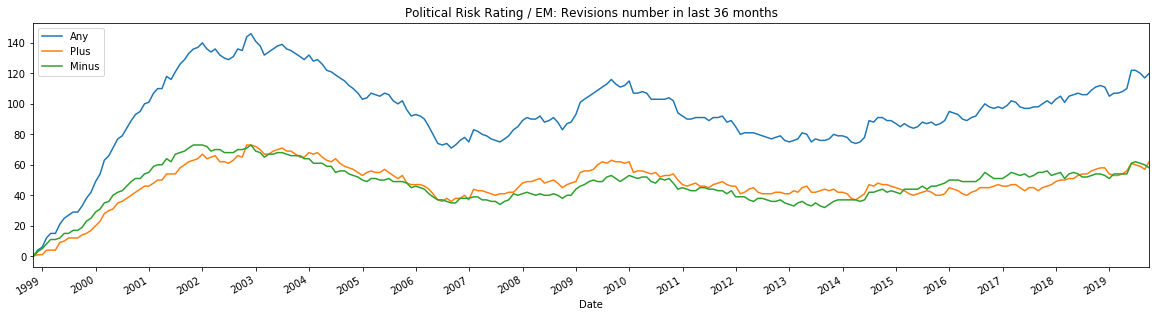

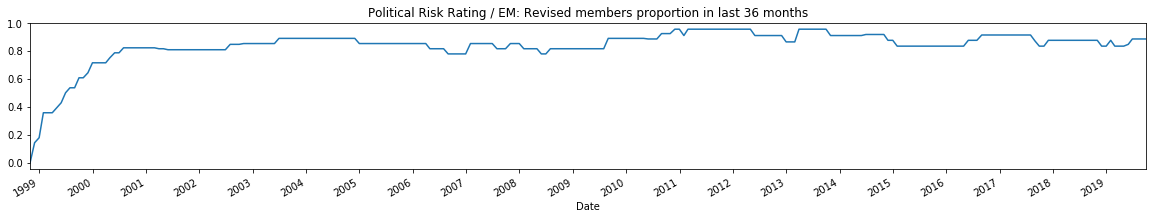

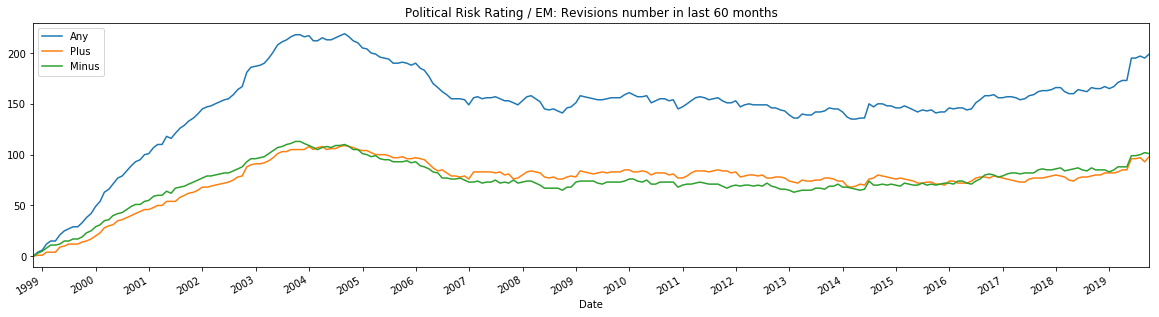

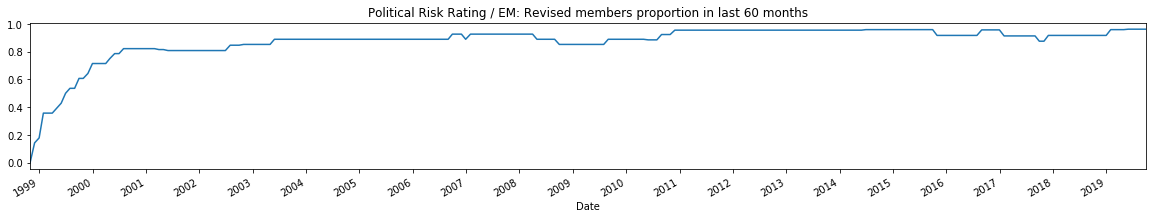

Political Risk Rating : EM markets ( 6400 ) : Countries covered: 31
Political Risk Rating : EM markets ( 6400 ) : Average observations per country: 206.45
Political Risk Rating : EM markets ( 6400 ) : Mean coverage per country: 100.00%
Political Risk Rating : EM markets ( 6400 ) : Any revisions frequency: 11.44% ( 732 )
Political Risk Rating : EM markets ( 6400 ) : Positive revisions frequency: 5.78% ( 370 )
Political Risk Rating : EM markets ( 6400 ) : Negative revisions frequency: 5.66% ( 362 )
Political Risk Rating : EM markets ( 6400 ) : Average revisions number for country: 23.61
Political Risk Rating : EM markets ( 6400 ) : Average stable rating period lentgh (months): 8.49
Political Risk Rating : EM markets: Mean revision absolute step: 1.01
Political Risk Rating : EM markets: Mean revision positive step: 1.01
Political Risk Rating : EM markets: Mean revision negative step: -1.01
Political Risk Rating : EM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 qu

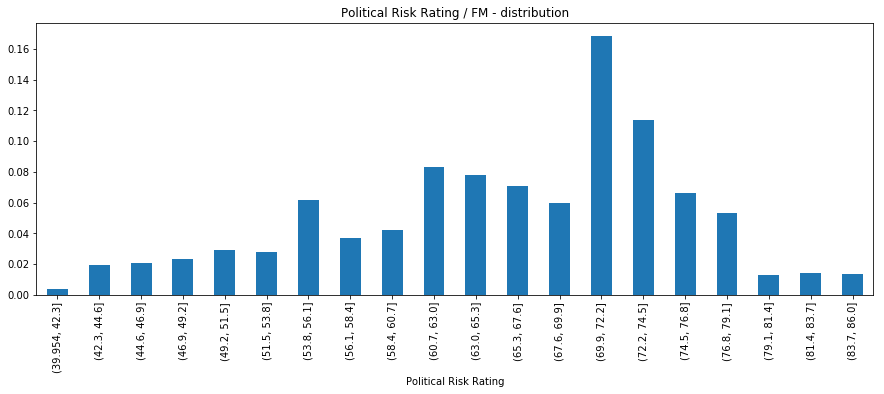

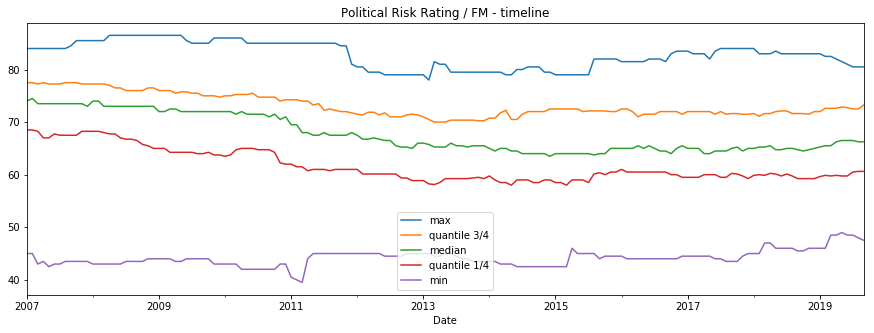

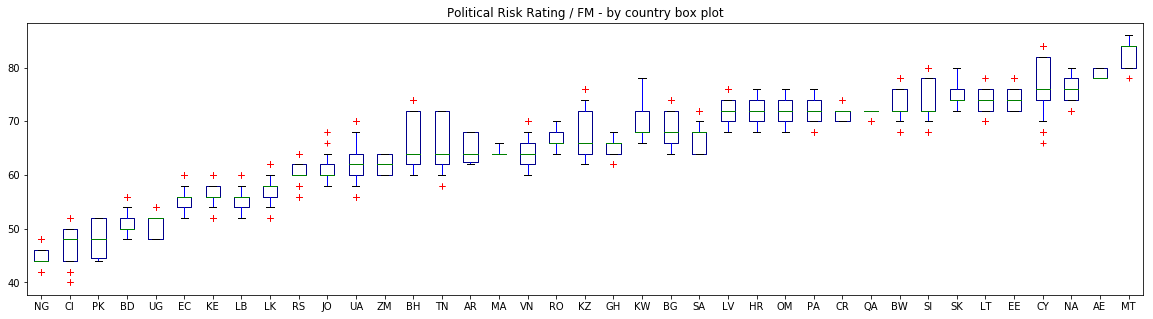

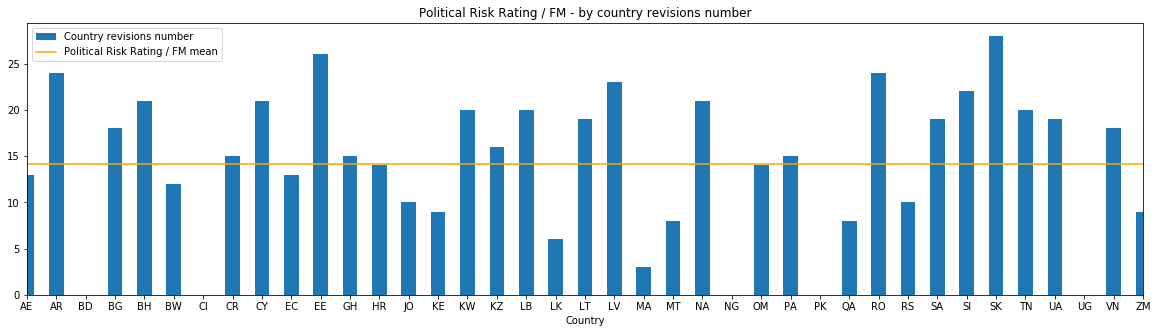

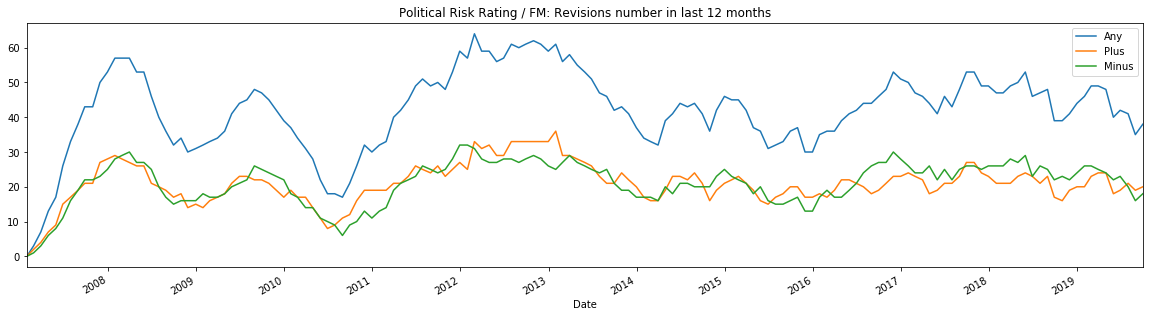

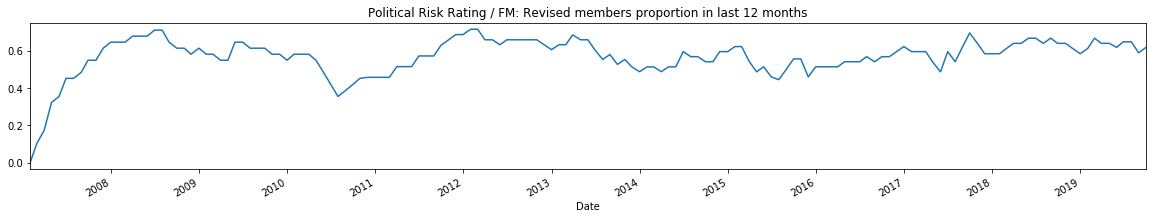

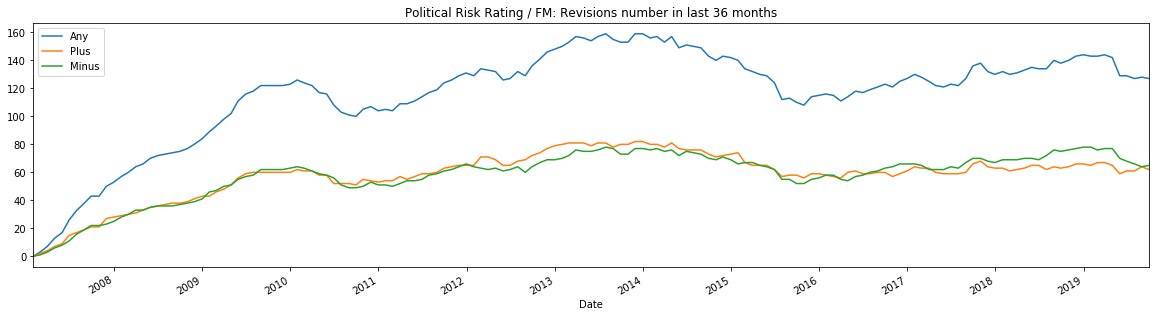

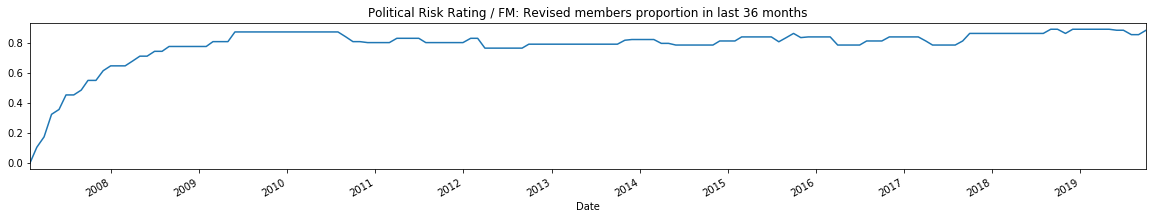

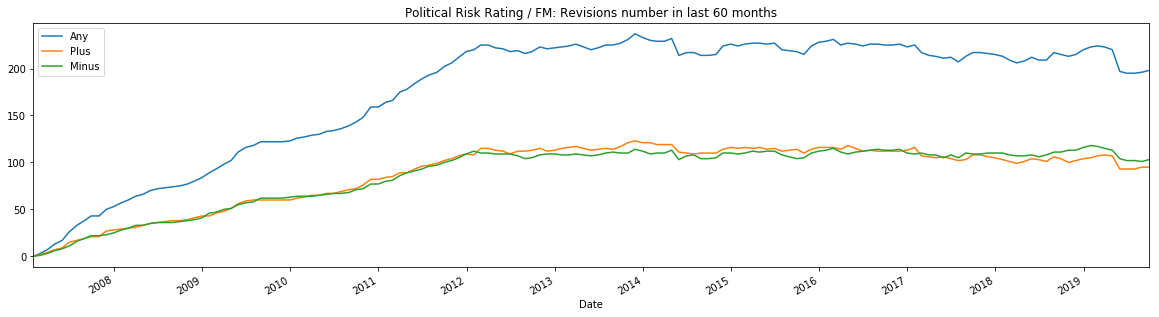

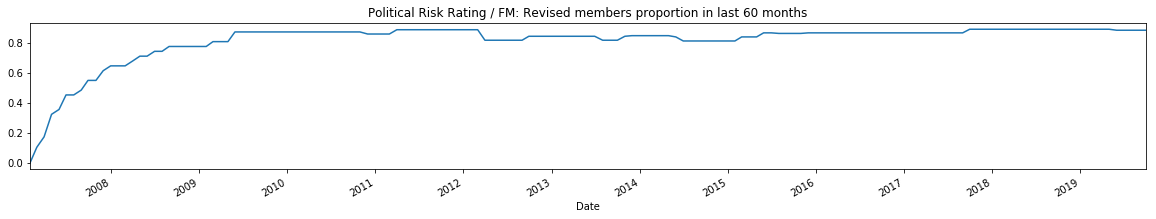

Political Risk Rating : FM markets ( 5345 ) : Countries covered: 39
Political Risk Rating : FM markets ( 5345 ) : Average observations per country: 137.05
Political Risk Rating : FM markets ( 5345 ) : Mean coverage per country: 100.00%
Political Risk Rating : FM markets ( 5345 ) : Any revisions frequency: 10.35% ( 553 )
Political Risk Rating : FM markets ( 5345 ) : Positive revisions frequency: 5.18% ( 277 )
Political Risk Rating : FM markets ( 5345 ) : Negative revisions frequency: 5.16% ( 276 )
Political Risk Rating : FM markets ( 5345 ) : Average revisions number for country: 14.18
Political Risk Rating : FM markets ( 5345 ) : Average stable rating period lentgh (months): 9.01
Political Risk Rating : FM markets: Mean revision absolute step: 1.01
Political Risk Rating : FM markets: Mean revision positive step: 1.01
Political Risk Rating : FM markets: Mean revision negative step: -1.01
Political Risk Rating : FM markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 qu

In [6]:
### AGENCIES BEHAVIOR AND DISTRIBUTION ANALYZING
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
### Constants for universe filtering:
arr_tup_index = [(All, All, All), (All, All, 'DM'), (All, All, 'EM'), (All, All, 'FM')]
arr_tup_market = ['All', 'DM', 'EM', 'FM']
num_rating_round_level = 2
num_quantile_bins = 10
#arr_tup_index = [(All, All, All), (All, 'DM', All), (All, ['EM', 'FM'], All)]
#arr_tup_market = ['All', 'DM', 'EM & FM']
### Constants for rolling calculations:
arr_roll_max = [12, 36, 60]
### Function for calculating length of constant rating periods:
def rolling_count(iter_delta):
    if (iter_delta == 0):
        rolling_count.iter_counter = rolling_count.iter_counter + 1
        rolling_count.iter_result = 0
    else:
        rolling_count.iter_result = rolling_count.iter_counter
        rolling_count.iter_counter = 1
    return rolling_count.iter_result
rolling_count.iter_counter = 1 
rolling_count.iter_result = 0
### Main loop:
for iter_risk in df_politics_main.columns: ### Agencies iterating
    for iter_num, iter_tup_market in enumerate(arr_tup_index):  ### Universe filters iterating
        ### Grades series defining:
        iter_ser_grades = df_politics_main.loc[iter_tup_market, iter_risk].dropna().sort_index(level = ['Country', 'Date'], ascending = [True, True])        
        ### Counter for country rankings:
        iter_ser_counter = iter_ser_grades.groupby('Country').count()
        ### Deltas series calculation:
        iter_ser_deciles = df_politics_main.loc[All, iter_risk].groupby('Date').transform(lambda iter_group: pd.qcut(iter_group, q = num_quantile_bins, 
                                                                                                                     labels = False, duplicates = 'drop'))        
        iter_ser_deltas = iter_ser_deciles.dropna().groupby('Country').diff().sort_index(level = ['Country', 'Date'], ascending = [True, True])
        ### Rolling revisions number for every date calculation:
        arr_df_roll_flag_date = {}
        arr_df_roll_flag_market = {}    
        arr_df_crosstab = {}        
        for iter_roll_max in arr_roll_max:
            num_roll_max = iter_roll_max
            num_roll_min = 2 # num_roll_max // 2
            iter_ser_flag = iter_ser_deltas.copy()
            iter_ser_flag[iter_ser_flag != 0] = iter_ser_flag / iter_ser_flag.abs()
            iter_ser_flag_plus = iter_ser_flag.copy()
            iter_ser_flag_plus[iter_ser_flag_plus != 1] = 0
            iter_ser_flag_minus = iter_ser_flag.copy()
            iter_ser_flag_minus[iter_ser_flag_minus != -1] = 0
            iter_ser_roll_flag_plus = iter_ser_flag_plus.groupby('Country').rolling(window = num_roll_max, min_periods = num_roll_min).sum()
            iter_ser_roll_flag_plus = iter_ser_roll_flag_plus.reset_index(level = 0, drop = True)
            iter_ser_roll_flag_minus = iter_ser_flag_minus.abs().groupby('Country').rolling(window = num_roll_max, min_periods = num_roll_min).sum()
            iter_ser_roll_flag_minus = iter_ser_roll_flag_minus.reset_index(level = 0, drop = True)
            iter_ser_roll_flag = iter_ser_roll_flag_plus + iter_ser_roll_flag_minus
            iter_df_roll_flag = pd.concat([iter_ser_roll_flag, iter_ser_roll_flag_plus, iter_ser_roll_flag_minus], axis = 1)
            iter_df_roll_flag.sort_index(level = ['Country', 'Date'], ascending = [True, True], inplace = True)  
            iter_df_roll_flag = iter_df_roll_flag.loc[iter_tup_market, All]
            iter_df_roll_flag.columns = ['Any', 'Plus', 'Minus']
            iter_df_roll_flag_date = iter_df_roll_flag.groupby('Date').sum()          
            arr_df_roll_flag_date[num_roll_max] = iter_df_roll_flag_date
            iter_df_roll_flag_market_all = iter_df_roll_flag.groupby('Date')
            iter_df_roll_flag_market_revised = iter_df_roll_flag[iter_df_roll_flag['Any'] > 0].groupby('Date')
            iter_df_roll_flag_market = iter_df_roll_flag_market_revised.count().div(iter_df_roll_flag_market_all.count())['Any']
            iter_df_roll_flag_market.fillna(0, inplace = True)
            arr_df_roll_flag_market[num_roll_max] = iter_df_roll_flag_market            
        ### Constant periods lengths series calculation:
        iter_ser_deltas = iter_ser_deltas.shift(-1)    
        iter_ser_distances = iter_ser_deltas.apply(rolling_count)
        iter_ser_distances = iter_ser_distances.loc[iter_tup_market]
        iter_ser_deltas = iter_ser_deltas.shift()  
        iter_ser_deltas = iter_ser_deltas.loc[iter_tup_market]
        ### Deltas number for countries calculation:        
        iter_ser_deltas_countries = iter_ser_deltas.dropna()[iter_ser_deltas != 0].groupby('Country').count()
        iter_ser_deltas_countries = iter_ser_deltas_countries / iter_ser_deltas.dropna().groupby('Country').count()
        iter_ser_deltas_countries.fillna(0, inplace = True)
        iter_ser_deltas_countries = iter_ser_deltas_countries * iter_ser_deltas.dropna().groupby('Country').count()
        
        iter_ser_deltas_countries.name = 'Country revisions number'
        ### Mean deltas for universe filter:
        iter_ser_deltas_mean = pd.Series(iter_ser_deltas_countries.mean(), index = iter_ser_deltas_countries.index)        
        iter_ser_deltas_mean.name = iter_risk + ' / ' + arr_tup_market[iter_num] + ' mean'
        ### Filtered universe grades distribution drawing:
        (iter_ser_grades.groupby(pd.cut(iter_ser_grades.round(), 20)).count() / iter_ser_grades.count()).plot(figsize = (15, 5), kind = 'bar', 
                                                                                          title = iter_risk + ' / ' + arr_tup_market[iter_num] + ' - distribution')
        plt.show()        
        ### Timeline for filtered market time-series aggregating:
        grouper_market_by_country = iter_ser_grades.groupby('Country')
        ### Timeline for filtered market plotting:
        grouper_market_by_date = iter_ser_grades.groupby('Date')
        df_timeline_market = pd.concat([grouper_market_by_date.max(), grouper_market_by_date.quantile(0.75), grouper_market_by_date.median(), 
                                        grouper_market_by_date.quantile(0.25), grouper_market_by_date.min()], axis = 1)
        df_timeline_market.columns = ['max', 'quantile 3/4', 'median', 'quantile 1/4', 'min']
        df_timeline_market.plot(figsize = (15, 5), title = iter_risk + ' / ' + arr_tup_market[iter_num] + ' - timeline')
        plt.show()        
        ### Timeline for filtered countries plotting:
        dict_color = {'boxes': 'DarkBlue', 'medians': 'Green', 'whiskers': 'Blue', 'caps': 'Black'}
        iter_ser_grades_rounded = (iter_ser_grades / num_rating_round_level).round() * num_rating_round_level
        iter_ser_grades_rounded.unstack('Country').reindex(iter_ser_grades_rounded.unstack('Country').median().sort_values().index, axis = 1).plot.box(figsize = (20, 5), 
                                                                                title = iter_risk + ' / ' + arr_tup_market[iter_num] + ' - by country box plot',
                                                                                color = dict_color, sym = 'r+', whis = [10, 90])
        plt.show()
        ### Revisions number for filtered countries plotting:        
        iter_ser_deltas_countries.plot.bar(figsize = (20, 5), title = iter_risk + ' / ' + arr_tup_market[iter_num] + ' - by country revisions number',
                                           legend = True, width = 0.5)
        iter_ser_deltas_mean.plot(color = 'Orange', legend = True)
        plt.show()
        for iter_roll_max in arr_roll_max:           
            ### Revisions number by date plotting:
            num_roll_max = iter_roll_max
            iter_df_roll_flag_date = arr_df_roll_flag_date[num_roll_max]
            plot_roll_flag_date = iter_df_roll_flag_date.plot(figsize = (20, 5), x_compat = True)
            plot_roll_flag_date.set_title(iter_risk + ' / ' +  arr_tup_market[iter_num] + ': Revisions number in last ' + str(num_roll_max) + ' months')
            plot_roll_flag_date.xaxis.set_major_locator(mdates.YearLocator())
            plt.gcf().autofmt_xdate()
            plt.show() 
            
            iter_df_roll_flag_market = arr_df_roll_flag_market[num_roll_max]
            plot_roll_flag_market = iter_df_roll_flag_market.plot(figsize = (20, 3), x_compat = True)
            plot_roll_flag_market.set_title(iter_risk + ' / ' +  arr_tup_market[iter_num] + ': Revised members proportion in last ' + str(num_roll_max) + ' months')
            plot_roll_flag_market.xaxis.set_major_locator(mdates.YearLocator())    
            plt.gcf().autofmt_xdate()
            plt.show()             
        ### Displaying statistics for filtered universe:
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Countries covered:', iter_ser_counter.count())   
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Average observations per country:', round(iter_ser_counter.mean(), 2)) 
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Mean coverage per country:', '{:.2%}'.format((iter_ser_counter / iter_ser_grades.fillna(0).groupby('Country').count()).mean()))
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Any revisions frequency:', '{:.2%}'.format(len(iter_ser_deltas.dropna()[iter_ser_deltas != 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_deltas.dropna()[iter_ser_deltas != 0].index), ')')
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Positive revisions frequency:', '{:.2%}'.format(len(iter_ser_deltas[iter_ser_deltas > 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_deltas[iter_ser_deltas > 0].index), ')')  
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Negative revisions frequency:', '{:.2%}'.format(len(iter_ser_deltas[iter_ser_deltas < 0].index) / iter_ser_grades.count()), 
              '(', len(iter_ser_deltas[iter_ser_deltas < 0].index), ')')
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Average revisions number for country:', round(iter_ser_deltas_countries.mean(), 2))        
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets (', iter_ser_grades.count(), ')',
              ': Average stable rating period lentgh (months):', 
              round(iter_ser_distances[iter_ser_distances > 0].mean(), 2)) 
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Mean revision absolute step:', 
              round(iter_ser_deltas.abs()[iter_ser_deltas != 0].mean(), 2))   
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Mean revision positive step:', 
              round(iter_ser_deltas[iter_ser_deltas > 0].mean(), 2))
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Mean revision negative step:', 
              round(iter_ser_deltas[iter_ser_deltas < 0].mean(), 2))
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Mean cross-sectional interquantile range (between 0.9 and 0.1 quantile):', 
              round((grouper_market_by_date.quantile(0.90) - grouper_market_by_date.quantile(0.10)).mean(), 2))
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Mean cross-sectional median:', 
              round(grouper_market_by_date.median().mean(), 2))       
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Mean country interquantile range (between 0.9 and 0.1 quantile):', 
              round((grouper_market_by_country.quantile(0.90) - grouper_market_by_country.quantile(0.10)).mean(), 2))
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Median country interquantile range (between 0.9 and 0.1 quantile):', 
              round((grouper_market_by_country.quantile(0.90) - grouper_market_by_country.quantile(0.10)).median(), 2))       
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets:  Mean absolute deviation for countries mean:', 
              round(grouper_market_by_country.mad().mean(), 2))         
        print(iter_risk, ':', arr_tup_market[iter_num], 'markets:  Mean absolute deviation for countries median:', 
              round(grouper_market_by_country.mad().median(), 2))        
        for iter_roll_max in arr_roll_max:
            num_roll_max = iter_roll_max
            iter_df_roll_flag_date = arr_df_roll_flag_date[num_roll_max]
            iter_df_roll_flag_market = arr_df_roll_flag_market[num_roll_max]
            print(iter_risk, ':', arr_tup_market[iter_num], 'markets (', len(iter_df_roll_flag_date.index), 'datepoints)',
                  ': Datepoints with at least one revision in last', num_roll_max,'months:', 
                  '{:.2%}'.format(len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] > 0].index) / len(iter_df_roll_flag_date.index)), 
                  '(', len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] > 0].index), ')')
            print(iter_risk, ':', arr_tup_market[iter_num], 'markets (', len(iter_df_roll_flag_date.index), 'datepoints)',
                  ': Datepoints with no revisions in last', num_roll_max,'months:', 
                  '{:.2%}'.format(len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] == 0].index) / len(iter_df_roll_flag_date.index)), 
                  '(', len(iter_df_roll_flag_date[iter_df_roll_flag_date['Any'] == 0].index), ')')
            print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Mean any revisions number in last', num_roll_max,'months from datepoint:',
                  round(iter_df_roll_flag_date['Any'].mean(), 2)) 
            print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Mean positive revisions number in last', num_roll_max,'months from datepoint:',
                  round(iter_df_roll_flag_date['Plus'].mean(), 2)) 
            print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Mean negative revisions number in last', num_roll_max,'months from datepoint:',
                  round(iter_df_roll_flag_date['Minus'].mean(), 2))   
            print(iter_risk, ':', arr_tup_market[iter_num], 'markets: Mean proportion of members revised in last', num_roll_max,'months from market:',
                  '{:.2%}'.format(round(iter_df_roll_flag_market.mean(), 4)))         

#        if (iter_num == 1):
#            break
#        break        
#    if (iter_risk == 'FITCH'):
#        break
#    break

In [ ]:
### ADDITIONAL POLITICAL DATA OBSERVATION

In [13]:
### DEFINING EXTRACTION UNIVERSE DATA FROM GENERAL MS EXCEL SOURCE
def get_market_membership_from_excel(path_msci):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Declaring local constants & variables: 
    tab_monthly = 'universe_joined'    
    arr_markets_needed = ['DM', 'FM', 'EM']   
    dict_markets = {50 : 'DM', 57 : 'EM', 504 : 'FM'}
    no_slice = slice(None)
    ### Extracting universe data:
    df_universe = pd.read_excel(io = path_msci, sheet_name = tab_monthly, skiprows = [0, 2], header = 0, parse_dates = True, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    df_universe = df_universe.loc[no_slice, ['dates', 'region', 'ctry']]
    df_universe.columns = ['Date', 'Market', 'Country']
    df_universe.set_index(['Date', 'Country'], inplace = True)
    ser_universe = df_universe.squeeze()
    ser_universe.sort_index(level = [0, 1], inplace = True)
    ser_universe.replace(dict_markets, inplace = True)
    ser_market_membership = ser_universe[ser_universe.isin(arr_markets_needed)]
    
    return ser_market_membership

In [14]:
def get_additional_political_data(path_politics, path_msci):
    ### Importing standard modules and date-special modules:
    import numpy as np
    import pandas as pd
    ### Loading data:
    df_politics = pd.read_excel(path_politics, index_col = [0, 5, 6], parse_dates = True, 
                                na_values = ['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', 
                                             '1.#QNAN', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'], keep_default_na = False)
    ### Mungling table:
    df_politics = df_politics.iloc[: , 4 : ].stack().to_frame()
    df_politics.index.names = ['Country', 'Indicator', 'Group', 'Date_Q']
    df_politics.reset_index('Date_Q', inplace = True)    
    ### Date manipulating:
    df_politics['Date'] = pd.to_datetime(df_politics['Date_Q']) + pd.offsets.BQuarterEnd()
    df_politics.set_index('Date', append = True, inplace = True)
    df_politics.drop('Date_Q', axis = 1, inplace = True)    
    df_politics = df_politics.groupby(['Country', 'Indicator', 'Group']).\
        apply(lambda iter_group: iter_group.droplevel([0, 1, 2]).resample('BM').bfill())
    df_politics = df_politics.reorder_levels(['Date', 'Country', 'Indicator', 'Group'])
    df_politics.columns = ['Value']
    ### Market membership importing:
    ser_market_membership = get_market_membership_from_excel(path_msci)
    ### Adding membership column to result dataframe:    
    df_politics = df_politics.join(ser_market_membership, on = ['Date', 'Country'], how = 'left')
    df_politics = df_politics.set_index('Market', drop = True, append = True)    
    ### Dropping countries with no participation in ISON universe:
    ser_politics = df_politics.loc[(All, ser_market_membership.index.get_level_values(1).unique().to_list(), All), All].squeeze()
    ### Dropping group index and formatting table:
    ser_politics.reset_index('Group', drop = True, inplace = True)
    df_result = ser_politics.unstack('Indicator').sort_index(level = ['Country', 'Date']) 
    
    return df_result

In [17]:
### MAIN SCRIPT
### Importing standard modules and date-special modules:
import numpy as np
import pandas as pd
### Declaring global constants & variables: 
path_msci = 'Data_Files/Source_Files/sample_universe.xlsx' ### Path for membership source
path_politics = 'Data_Files/Source_Files/political_data_plus.xlsx' ### Path for membership source
All = slice(None)
get_market_membership_from_excel(path_msci)
df_politics = get_additional_political_data(path_politics, path_msci)
df_politics.to_excel('Data_Files/Test_Files/Politics_Plus.xlsx', merge_cells = False)
#ser_politics_main = ser_politics.loc[(All, All, ['DM', 'EM', 'FM']), ['Composite Risk Rating', 'Economic Risk Rating', 'Financial Risk Rating', 'Political Risk Rating']]

In [16]:
df_politics.loc[(All, 'NA', All), :]

Indicator                  Banking Sector  Business Environment  Demography  \
Date       Country Market                                                     
2005-09-30 NA      NaN               7.56                  5.52        9.26   
2005-10-31 NA      NaN               6.69                  5.52        9.26   
2005-11-30 NA      NaN               6.69                  5.52        9.26   
2005-12-30 NA      NaN               6.69                  5.52        9.26   
2006-01-31 NA      NaN               6.23                  5.52        9.26   
...                                   ...                   ...         ...   
2019-05-31 NA      FM                8.14                  5.07        8.78   
2019-06-28 NA      FM                8.14                  5.07        8.78   
2019-07-31 NA      FM                7.82                  5.12        8.75   
2019-08-30 NA      FM                7.82                  5.12        8.75   
2019-09-30 NA      FM                7.82                  5.12        8.75   

Indicator                  Domestic Political Risk  \
Date       Country Market                            
2005-09-30 NA      NaN                        8.56   
2005-10-31 NA      NaN                        8.56   
2005-11-30 NA      NaN                        8.56   
2005-12-30 NA      NaN                        8.56   
2006-01-31 NA      NaN                        8.56   
...                                            ...   
2019-05-31 NA      FM                         7.29   
2019-06-28 NA      FM                         7.29   
2019-07-31 NA      FM                         7.31   
2019-08-30 NA      FM                         7.31   
2019-09-30 NA      FM                         7.31   

Indicator                  External Adjustment Capacity (Pillar I)  \
Date       Country Market                                            
2005-09-30 NA      NaN                                        6.79   
2005-10-31 NA      NaN                                        6.84   
2005-11-30 NA      NaN                                        6.84   
2005-12-30 NA      NaN                                        6.84   
2006-01-31 NA      NaN                                        6.98   
...                                                            ...   
2019-05-31 NA      FM                                         5.87   
2019-06-28 NA      FM                                         5.87   
2019-07-31 NA      FM                                         5.89   
2019-08-30 NA      FM                                         5.89   
2019-09-30 NA      FM                                         5.89   

Indicator                  Fiscal Policy Anchor Strength  \
Date       Country Market                                  
2005-09-30 NA      NaN                              9.71   
2005-10-31 NA      NaN                              9.71   
2005-11-30 NA      NaN                              9.71   
2005-12-30 NA      NaN                              9.71   
2006-01-31 NA      NaN                              9.71   
...                                                  ...   
2019-05-31 NA      FM                               5.09   
2019-06-28 NA      FM                               5.09   
2019-07-31 NA      FM                               4.71   
2019-08-30 NA      FM                               4.71   
2019-09-30 NA      FM                               4.71   

Indicator                  Human Resource Potential  Infrastructure  \
Date       Country Market                                             
2005-09-30 NA      NaN                         3.99            4.04   
2005-10-31 NA      NaN                         3.99            4.04   
2005-11-30 NA      NaN                         3.99            4.04   
2005-12-30 NA      NaN                         3.99            4.04   
2006-01-31 NA      NaN                         4.06            4.04   
...                                             ...             ...   
2019-05-3